# Data preparation

In [1]:
%load_ext autoreload
%autoreload 0
%aimport -bokeh
%aimport -pandas
%aimport -aiohttp
%aimport -pd
import json
from src.ingestion.download_related_paper_datasets import download_related_paper_datasets
from src.ingestion.download_samples import download_samples
import seaborn as sns
from wordcloud import WordCloud
from io import StringIO
import matplotlib.pyplot as plt
from src.analysis.analyzer import DatasetAnalyzer
from src.visualization.visualize_clusters import visualize_clusters_jupyter
from src.visualization.get_topic_table import get_topic_table
import aiohttp
import asyncio
import pandas as pd
import itertools
import spacy
import scispacy
from scispacy.linking import EntityLinker
from src.model.geo_dataset import GEODataset
from src.model.geo_sample import GEOSample
from typing import Tuple, List, Dict, Set
from dateutil.parser import parse as parse_date
import datetime
from src.parsing.age.get_age import get_sample_ages
from src.tissue_and_cell_type_standardization.standardization_resources import StandardizationResources

In [2]:
paper_export = json.load(open("GEO_Datasets/pubmed-hallmarks-of-aging-an-expanding-universe.json"))
datasets = download_related_paper_datasets(paper_export)
print(len(datasets))

391


# Dataset metadata

## Experiment types

In [3]:
experiment_types = [dataset.experiment_type for dataset in datasets]
print(experiment_types[0:10])

['Expression profiling by high throughput sequencing', 'Methylation profiling by array', 'Expression profiling by array', 'Expression profiling by high throughput sequencing', 'Expression profiling by high throughput sequencing', 'Expression profiling by high throughput sequencing', 'Expression profiling by high throughput sequencing', 'Expression profiling by array', 'Expression profiling by array', 'Genome binding/occupancy profiling by high throughput sequencing']


/home/Momir.Milutinovic/repos/pubmed-paper-exploration/.venv/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 9.444444444444438, 'Count')

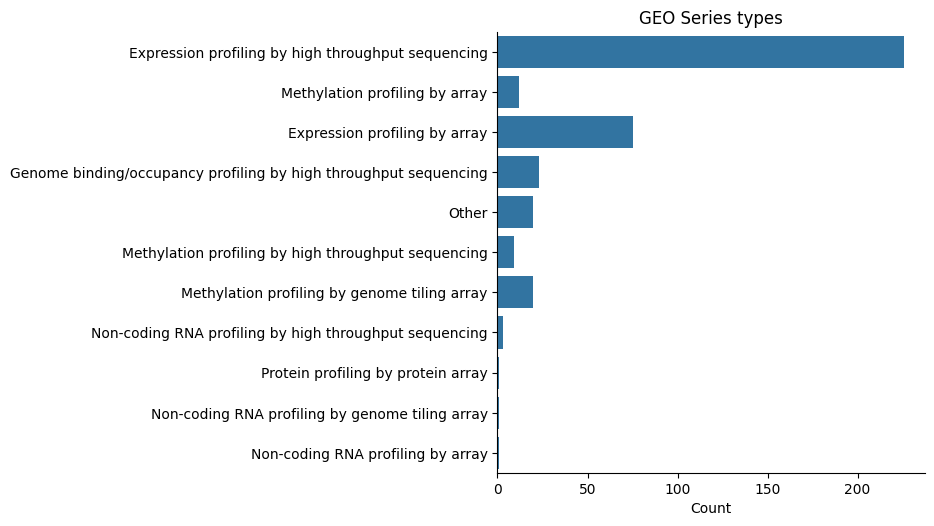

In [4]:
sns.catplot(experiment_types, kind="count")
plt.title("GEO Series types")
plt.xlabel("Count")

Most experiments are done through expression profiling by high throughput sequencing.

## Organisms

In [5]:
def replace_low_frequency_levels_with_other(pd_series, threshold):
    value_counts = pd_series.value_counts()
    low_freq_categories = value_counts[value_counts < threshold].index

    # Replace low-frequency categories with "Other"
    return pd_series.where(~pd_series.isin(low_freq_categories), 'Other')

49
Homo sapiens              210
Mus musculus              152
Other                      75
Rattus norvegicus          12
Caenorhabditis elegans     11
Name: count, dtype: int64
0.39622641509433965
391


Text(0.5, 9.444444444444438, '# Series')

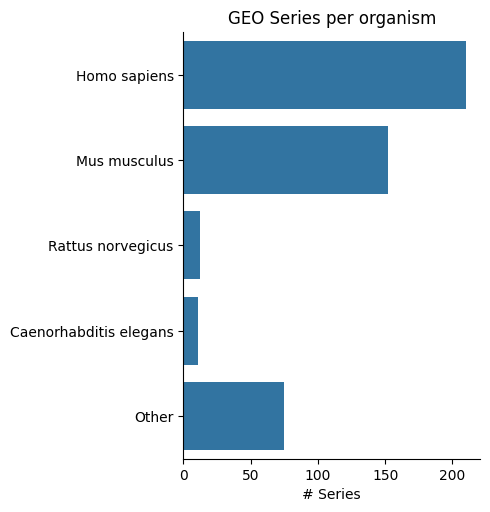

In [6]:
organisms = [organism for dataset in datasets for organism in dataset.organisms]
print(len(set(organisms)))
organisms = pd.Series(organisms)
organisms = replace_low_frequency_levels_with_other(organisms, 10)
print(organisms.value_counts())
print((147)/371)
print(len(datasets))
sns.catplot(organisms, kind="count", order=["Homo sapiens", "Mus musculus", "Rattus norvegicus", "Caenorhabditis elegans", "Other"])
plt.title("GEO Series per organism")
plt.xlabel("# Series")

Most datasets are collected from either mice or people.

In [7]:
## Title wordcolud

In [8]:
from typing import List
def plot_wordcloud(strings: List[str]):
    """
    Plots a wordcloud of a list of strings.
    """
    si = StringIO()
    for string in strings:
        si.write(string)
    text = si.getvalue()
    wordcloud = WordCloud().generate(text)
    wordcloud = WordCloud(background_color="white",max_words=len(text),max_font_size=40,).generate(text)
    plt.figure()
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

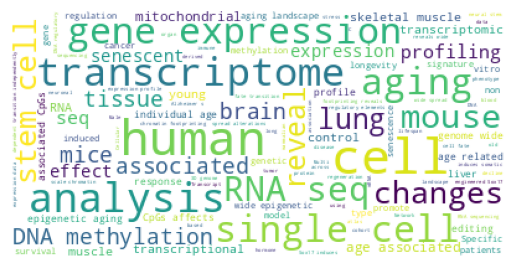

In [9]:
plot_wordcloud([dataset.title for dataset in datasets])

## Summary wordcolud

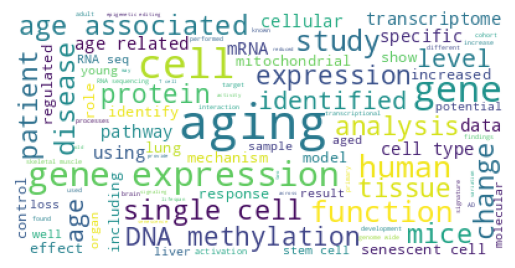

In [10]:
plot_wordcloud([dataset.summary for dataset in datasets])


## Overall design wordcolud

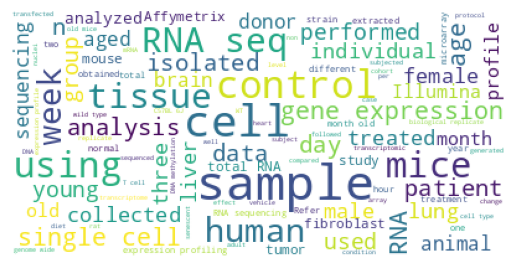

In [11]:
plot_wordcloud([dataset.overall_design for dataset in datasets])

## Platform ID counts

<Figure size 1000x2000 with 0 Axes>

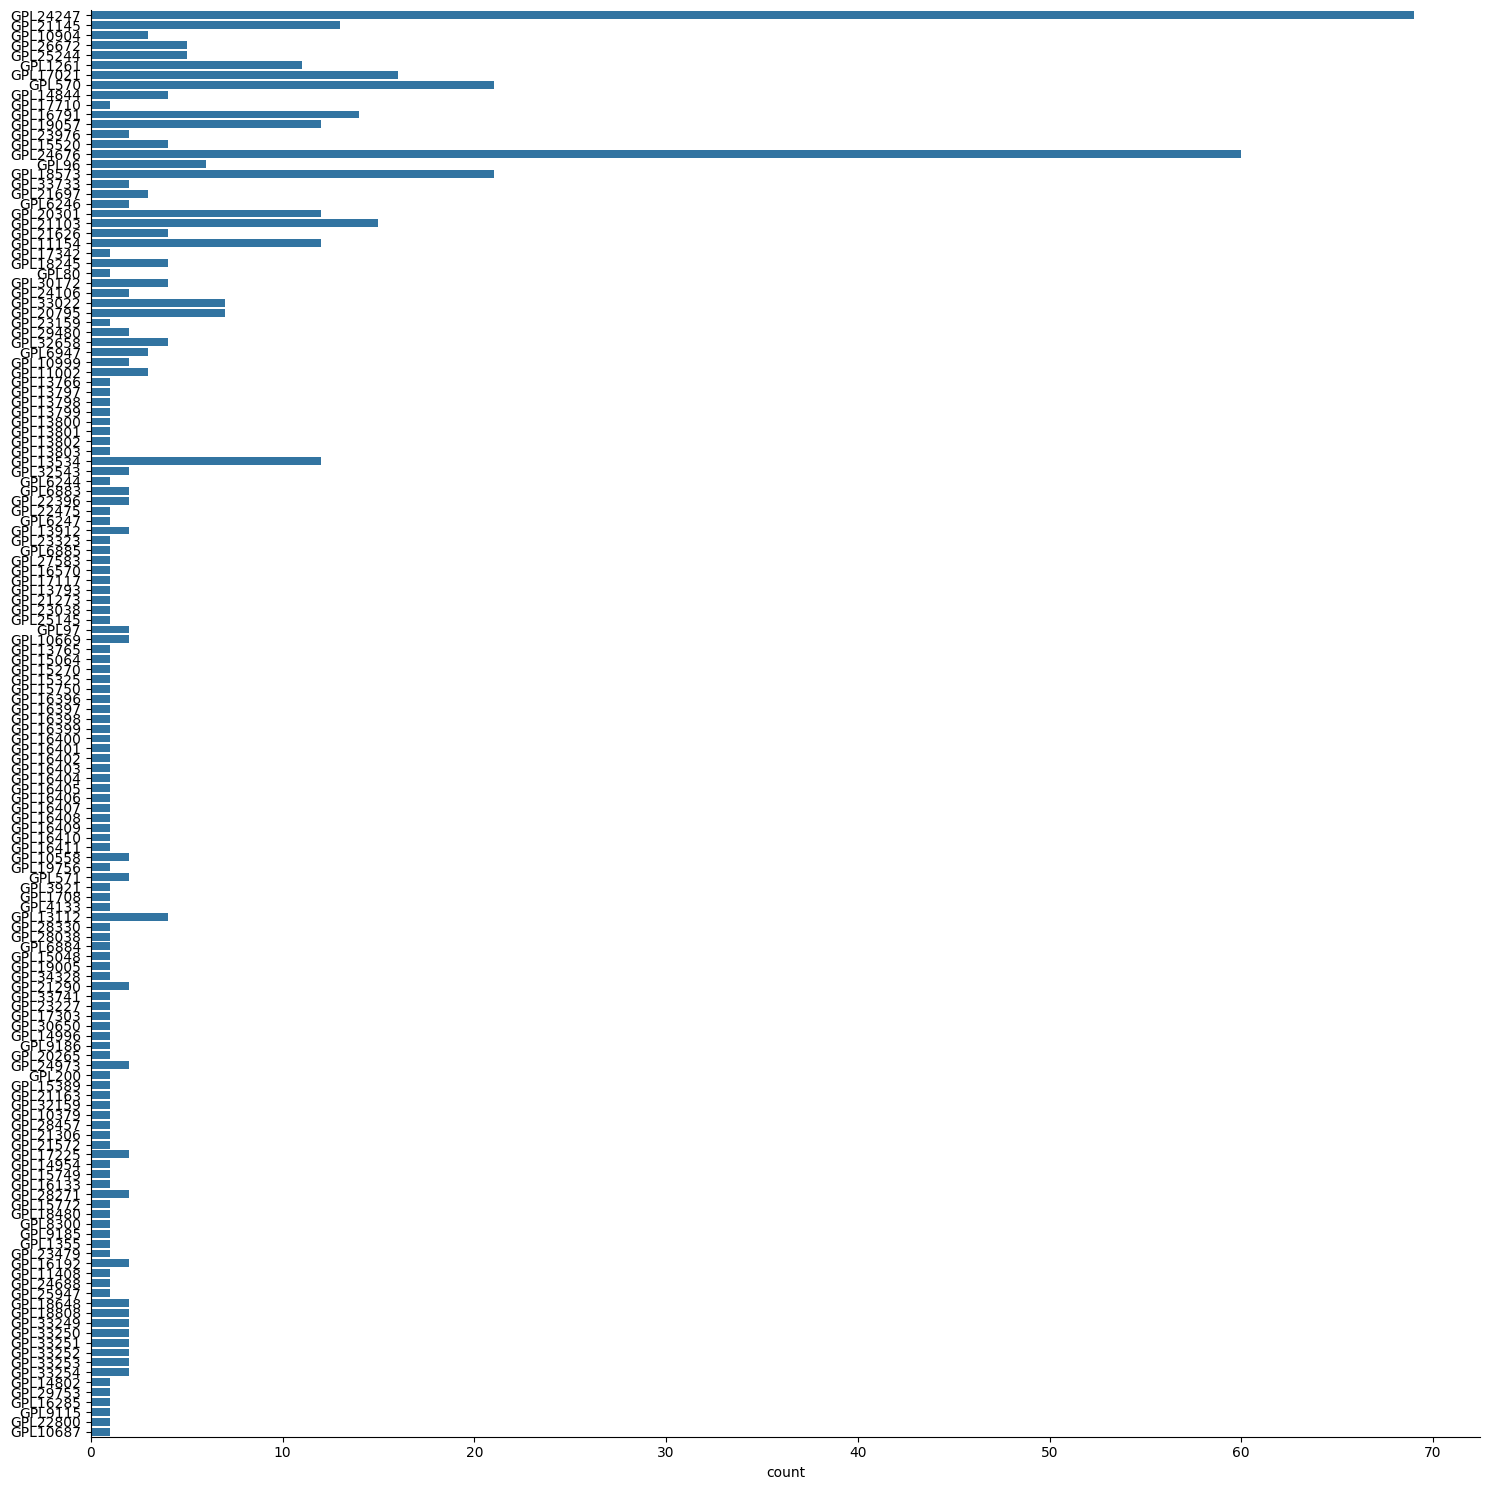

In [12]:
platform_ids = [platform_id for dataset in datasets for platform_id in dataset.platform_ids]
plt.figure(figsize=(10, 20))
sns.catplot(platform_ids, kind="count", height=15)
plt.show()

The top two platform IDs correspond to the Illumina Nova Seq 6000 sequencer. There is one platform record for when it is used and people and another one for mice. This is not surprising as Illumina sequencers are widely used in genomics research.

## Publication date

<Axes: title={'center': 'Datasets per year'}, xlabel='Year', ylabel='Number of datasets'>

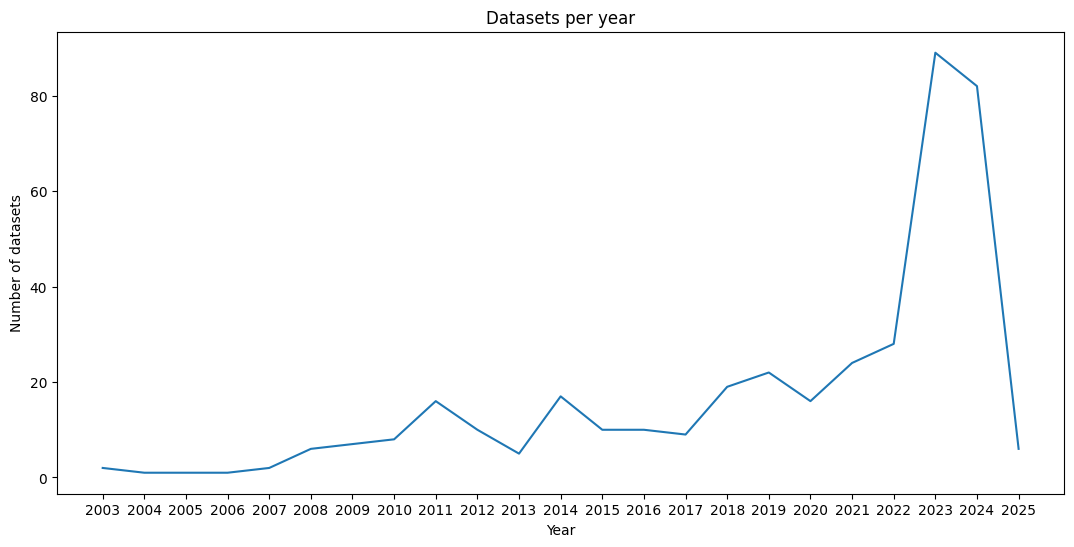

In [13]:
years = [str(dataset.publication_date.year) for dataset in datasets]
years = pd.DataFrame(years, columns=["year"])
years = years.groupby(["year"], as_index=False).agg(count=("year", "count"))
fig, ax = plt.subplots(figsize=(13, 6))
plt.title("Datasets per year")
plt.xlabel("Year")
plt.ylabel("Number of datasets")
sns.lineplot(years, x="year", y="count", ax=ax)

## Country

<Axes: title={'center': 'Number of datasets from each country'}, xlabel='count'>

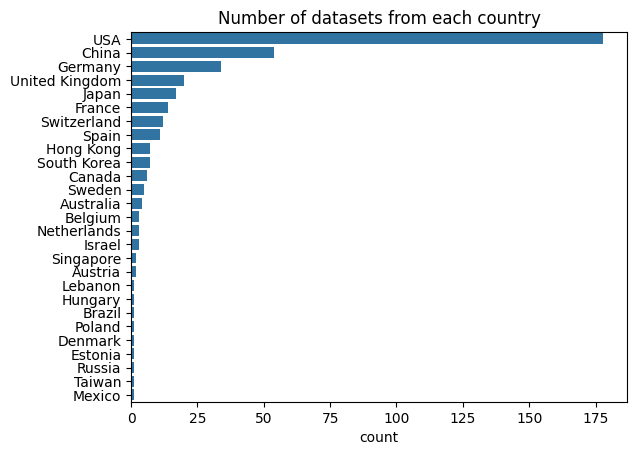

In [14]:
countries = pd.Series([dataset.metadata["contact_country"][0] for dataset in datasets])
plt.title("Number of datasets from each country")
sns.countplot(countries, order=countries.value_counts().index)

# Clustering

In [15]:
svd_dimensions = 15
topic_words = 10
best_result = None
best_score = -1
best_n_clusters = None

for n_clusters in range(5, 20):
    analyzer = DatasetAnalyzer(svd_dimensions, n_clusters)
    result = analyzer.analyze_datasets(datasets)
    if result.silhouette_score > best_score:
        best_score = result.silhouette_score
        best_result = result
        best_n_clusters = n_clusters

print(f"Best number of clusters {best_n_clusters}")

Best number of clusters 16


Similar datasets are located close to each other.
The color of a point represnts the topic of the dataset.

In [16]:
visualize_clusters_jupyter(best_result.df, best_result.cluster_topics)

Loading BokehJS ...

## Topics

In [17]:
topic_table = get_topic_table(best_result.cluster_topics, best_result.df)
topic_df = pd.DataFrame(topic_table, columns=["#", "Datasets", "Color", "Topics"])
topic_df = topic_df.set_index("#")
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
# Apply styling to the 'color' column
topic_df = topic_df[["Color", "Datasets", "Topics"]].style.map(lambda x: f"background-color: {x};" if type(x) == str and x.startswith("#") else "")\
    .map(lambda x: f"color: {x};" if type(x) == str and x.startswith("#") else "")
topic_df

# Sample metadata

In [18]:
# Download samples
samples = set() # We are using a set because some samples can occur twice. For example, a sample appears twice when it is in a subseries and superseries
async with aiohttp.ClientSession() as session:
    for series in datasets:
        try:
            series.samples = await download_samples(series, session)
            samples.update(series.samples)
        except aiohttp.ServerDisconnectedError:
            session = await session.close()
            session = aiohttp.ClientSession()
            series.samples = await download_samples(series, session)
            samples.update(series.samples)

accessions = [sample.accession for sample in samples]
assert len(set(accessions)) == len(samples)

## Number of samples

In [19]:
len(samples)

46438

## Number of samples per dataset

/tmp/ipykernel_2203439/3117547129.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_plot = n_samples_df.groupby(by="cats")["samples"].count()


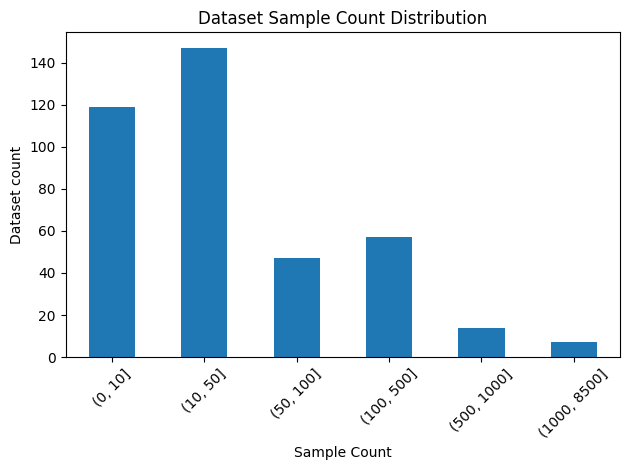

In [20]:
# https://stackoverflow.com/a/71540059
import scipy.stats as stats

number_of_samples_per_dataset = pd.Series(sorted([len(dataset.samples) for dataset in datasets]))
percent_of_samples_per_dataset = number_of_samples_per_dataset / number_of_samples_per_dataset.sum() 
n_samples_df = percent_of_samples_per_dataset.to_frame()
n_samples_df = n_samples_df.rename(columns={0: 'sample_share'})
n_samples_df["samples"] = number_of_samples_per_dataset

n = len(percent_of_samples_per_dataset)
#define bins in percent
#the last valueis slightly above 100% to ensure that the final bin is included
bins = [0, 10, 50, 100, 500, 1000, 8500]

def find_last_index(lst, condition):
    last_index = -1
    for index, value in enumerate(lst):
        if condition(value):
            last_index = index
    return last_index

rank_bins = [0] + [find_last_index(number_of_samples_per_dataset, lambda x: x <= bin) for bin in bins[1:-1]] + [len(number_of_samples_per_dataset)]
#create figure labels for intervals from bins
labels = [f"({start}, {stop}]" for start, stop in zip(bins[:-1], bins[1:])]


n_samples_df["cats"] = pd.cut(n_samples_df.index, bins=rank_bins, include_lowest=True, right=False, labels=labels)
#and aggregate
df_plot = n_samples_df.groupby(by="cats")["samples"].count()

df_plot.plot.bar(rot=45, xlabel="Sample Count", ylabel="Dataset count", title="Dataset Sample Count Distribution")

plt.tight_layout()
plt.show()

## Most common sample types

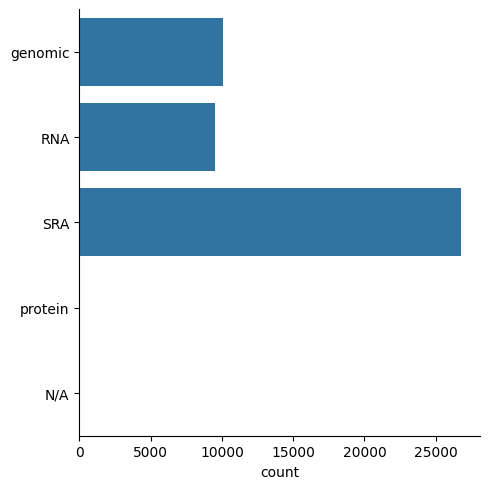

In [21]:
sample_types = [sample.sample_type for sample in samples]
sns.catplot(sample_types, kind="count")

## Most common characteristics keys

In [22]:
def remove_low_frequency_levels(pd_series, threshold):
    value_counts = pd_series.value_counts()
    low_freq_categories = value_counts[value_counts < threshold].index
    return pd_series[~pd_series.isin(low_freq_categories)]

Text(0.5, 1.0, 'Most common characterisitics keys')

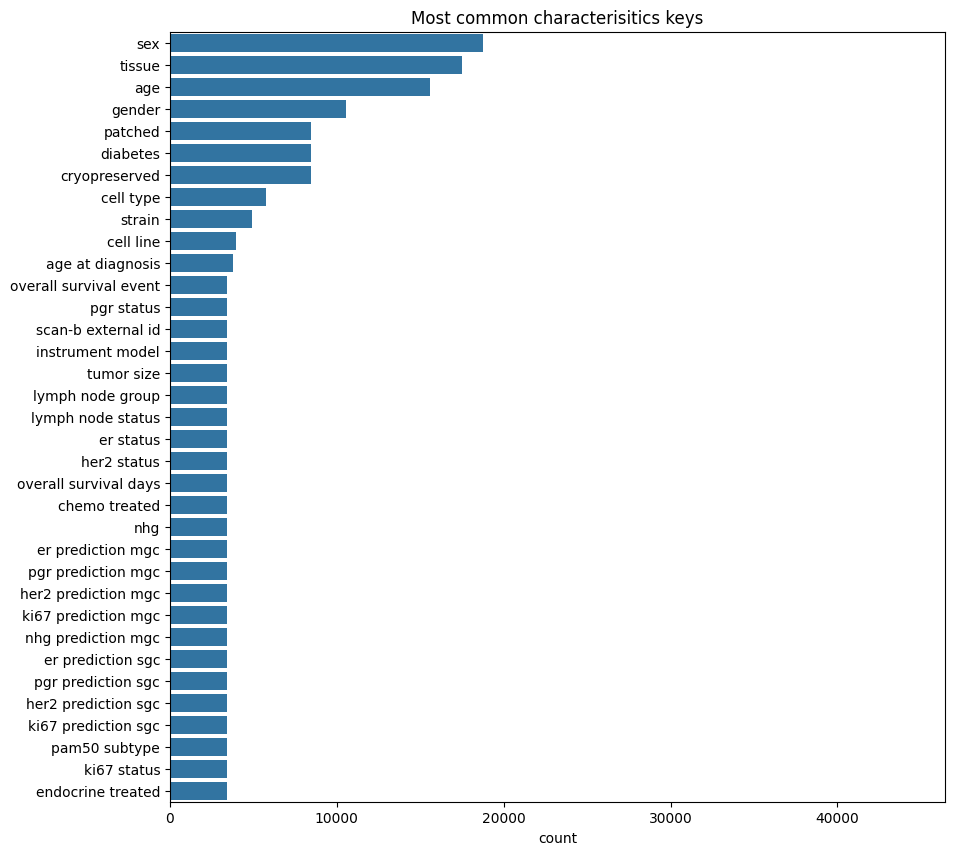

In [23]:
characteristics_keys = pd.Series([key for sample in samples for key in sample.characteristics])
frequent_characteristics_keys = remove_low_frequency_levels(characteristics_keys, 1000)
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim(0, len(samples))
sns.countplot(frequent_characteristics_keys, ax=ax, order=characteristics_keys.value_counts().index[0:35])
ax.set_title("Most common characterisitics keys")

In [24]:
pd.Series(characteristics_keys).value_counts().head(60)

sex                       18746
tissue                    17481
age                       15584
gender                    10581
patched                    8477
diabetes                   8477
cryopreserved              8477
cell type                  5754
strain                     4927
cell line                  3986
age at diagnosis           3781
overall survival event     3409
pgr status                 3409
scan-b external id         3409
instrument model           3409
tumor size                 3409
lymph node group           3409
lymph node status          3409
er status                  3409
her2 status                3409
overall survival days      3409
chemo treated              3409
nhg                        3409
er prediction mgc          3409
pgr prediction mgc         3409
her2 prediction mgc        3409
ki67 prediction mgc        3409
nhg prediction mgc         3409
er prediction sgc          3409
pgr prediction sgc         3409
her2 prediction sgc        3409
ki67 pre

## Number of samples that have data tables

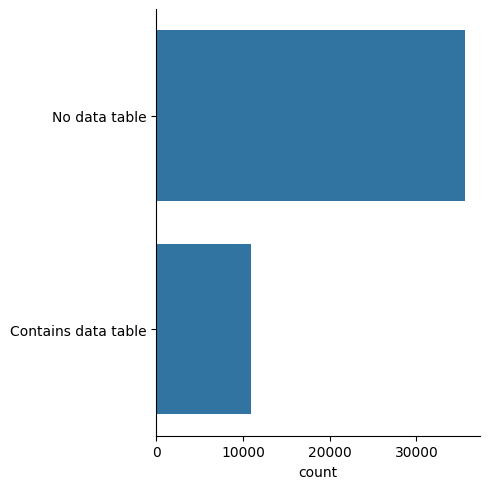

In [25]:
contains_data_table = ["Contains data table" if "data_row_count" in sample.metadata and sample.metadata["data_row_count"][0] != "0" else "No data table" for sample in samples]
sns.catplot(contains_data_table, kind="count")

It seems that relatively few samples have data tables. Therefore, most data is raw sequencing data. 

# What info can be found

In [26]:
def dataset_has_tissue_infomration(dataset: GEODataset):
    """
    Returns True if it is known which tissues were sampled for every
    sample in the dataset.
    All samples need to have the tissue characteric key for a dataset
    to be considered as having tissue information.
    If there are no samples in the datasets then the datasets does not have
    tissue information.

    :param datasets: GEODataset for which to check the presence of tissue information.
    :return: True if all samples have the 'tissue' characteristic key and there is
    at least one sample in the dataset, otherwise False.
    """
    if len(dataset.samples) == 0:
        return False
    return all("tissue" in sample.characteristics for sample in dataset.samples)

In [27]:
def dataset_has_sex_information(dataset: GEODataset):
    """
    Returns True if it the gender in the samples of a dataset is known.
    All samples need to have the sex or gender characteric keys 
    for a dataset to be considered as having sex information.
    If there are no samples in the datasets then the datasets does not have
    sex information.

    :param datasets: GEODataset for which to check the presence of sex information.
    :return: True if all samples have the 'sex' or 'gender' characteristic keys 
    and there is at least one sample in the dataset, otherwise False.
    """
    if len(dataset.samples) == 0:
        return False
    return all("sex" in sample.characteristics or "gender" in sample.characteristics for sample in dataset.samples)


In [28]:
def is_age_key(key: str):
    # We disqualify keys that contain the word "at" because then the age
    # becomes context-dependant.
    return ("age" in key.split(" ") or "age" in key.split("_")) and not "at" in key

for key in set(characteristics_keys):
    if is_age_key(key):
        print(key)

donor_age
age (yr)
age
age (years)
age_days
age_years
age (y)
age (yrs)
age group


In [29]:
def dataset_has_characteristics_key(dataset: GEODataset, characteristcs_key: str):
    """
    Returns True if all samples in the dataset have the specified key.
    """
    if len(dataset.samples) == 0:
        return False
    samples_contain_age_key = [any([(
        key == characteristcs_key) for key in sample.characteristics.keys()]) for sample in dataset.samples]
    return all(samples_contain_age_key)


In [30]:
def dataset_has_age_information(dataset: GEODataset):
    """
    Returns True if all samples in the dataset have a key
    that denotes age.
    """
    if len(dataset.samples) == 0:
        return False
    samples_contain_age_key = [any([is_age_key(
        key) for key in sample.characteristics.keys()]) for sample in dataset.samples]
    return all(samples_contain_age_key)

In [31]:
def is_dataset_about_humans(dataset: GEODataset):
    # A dataset has to be exclusively about humans
    return len(dataset.organisms) == 1 and dataset.organisms[0] == "Homo sapiens"

def is_dataset_about_mice(dataset: GEODataset):
    # A dataset has to be exclusively about mice
    return len(dataset.organisms) == 1 and dataset.organisms[0] == "Mus musculus"

In [32]:
human_datasets = list(filter(is_dataset_about_humans, datasets))
mice_datasets = list(filter(is_dataset_about_mice, datasets))

In [33]:
def add_percentages_to_countplot(ax, data, y_offset=1, total=None):
    # Calculate percentages and add text annotations
    total = len(data) if not total else total
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height() / total)
        x = p.get_x() + p.get_width() / 2
        y = p.get_height() + y_offset
        ax.text(x, y, percentage, ha='center')

/tmp/ipykernel_2203439/2279291711.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=datasets_have_sex_information, orient="v", palette=["red", "green"], order=["Absent", "Present"])


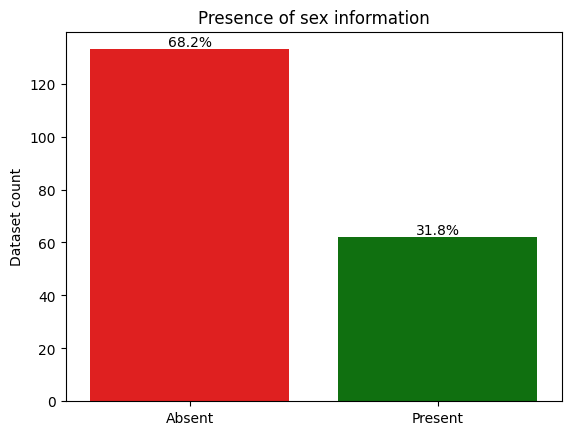

In [34]:
datasets_have_sex_information = pd.Series(["Present" if dataset_has_sex_information(dataset) else "Absent" for dataset in human_datasets])
ax = sns.countplot(x=datasets_have_sex_information, orient="v", palette=["red", "green"], order=["Absent", "Present"])
plt.title("Presence of sex information")
plt.xlabel("")
plt.ylabel("Dataset count")
add_percentages_to_countplot(ax, datasets_have_sex_information)

/tmp/ipykernel_2203439/4055054208.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=datasets_have_age_information, orient="v", palette=["red", "green"], order=["Absent", "Present"])


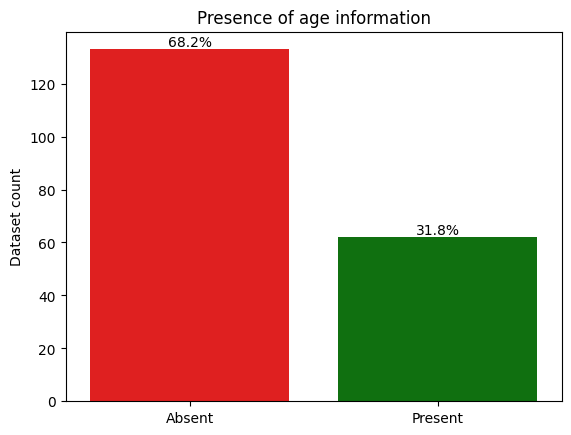

In [35]:
datasets_have_age_information = pd.Series(["Present" if dataset_has_age_information(dataset) else "Absent" for dataset in human_datasets])
ax = sns.countplot(x=datasets_have_age_information, orient="v", palette=["red", "green"], order=["Absent", "Present"])
plt.title("Presence of age information")
plt.xlabel("")
plt.ylabel("Dataset count")
add_percentages_to_countplot(ax, datasets_have_age_information)

/tmp/ipykernel_2203439/3140467400.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=datasets_have_tissue_information, orient="v", palette=["red", "green"], order=["Absent", "Present"])


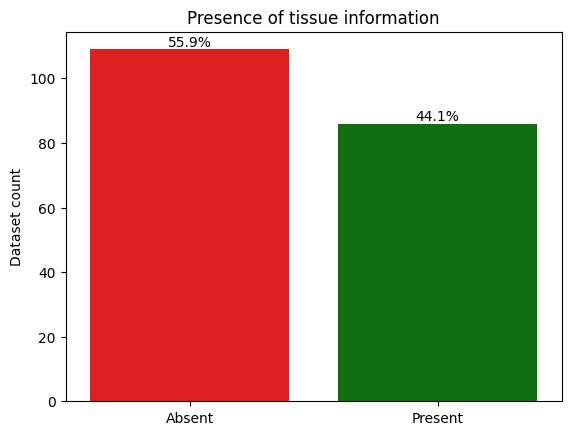

In [36]:
datasets_have_tissue_information = pd.Series(["Present" if dataset_has_characteristics_key(dataset, "tissue") else "Absent" for dataset in human_datasets])
ax = sns.countplot(x=datasets_have_tissue_information, orient="v", palette=["red", "green"], order=["Absent", "Present"])
plt.title("Presence of tissue information")
plt.xlabel("")
plt.ylabel("Dataset count")
add_percentages_to_countplot(ax, datasets_have_tissue_information)

[{'name': 'Tissue', 'available': 86, 'total': 195}, {'name': 'Age', 'available': 62, 'total': 195}, {'name': 'Sex', 'available': 62, 'total': 195}]


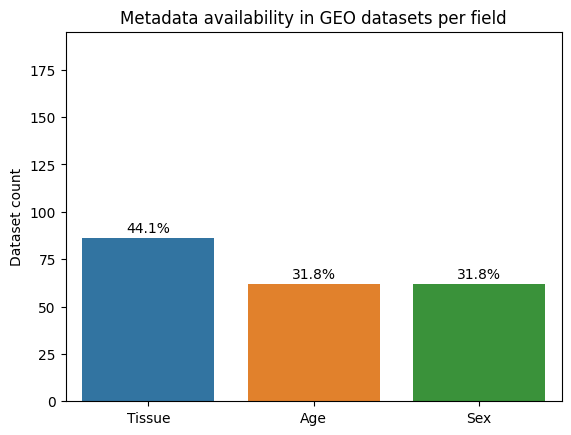

In [37]:
counts = [
    {
    "name": "Tissue",
    "available": datasets_have_tissue_information.value_counts()["Present"],
    "total": len(human_datasets)
    },
    {
    "name": "Age",
    "available": datasets_have_age_information.value_counts()["Present"],
    "total": len(human_datasets)
    },
    {
    "name": "Sex",
    "available": datasets_have_sex_information.value_counts()["Present"],
    "total": len(human_datasets)
    }
]
print(counts)
ax = sns.barplot(x="name", y="available", data=pd.DataFrame(counts), hue="name")
plt.title("Metadata availability in GEO datasets per field")
plt.xlabel("")
plt.ylabel("Dataset count")
plt.ylim((0, len(human_datasets)))

total = len(human_datasets)
add_percentages_to_countplot(ax, counts, y_offset=3, total=len(human_datasets))

In [38]:
def is_age_precise(dataset: GEODataset) -> str:
    sample_ages = get_sample_ages(dataset)
    if all(age is not None for age in sample_ages):
        return "Precise"
    if all(age is None for age in sample_ages):
        return "Imprecise"
    return "Mixed / has NAs"

/tmp/ipykernel_2203439/1975238076.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=ages_quantitative, order=["Imprecise", "Mixed / has NAs", "Precise"], orient="v", palette=["red", "yellow", "green"])


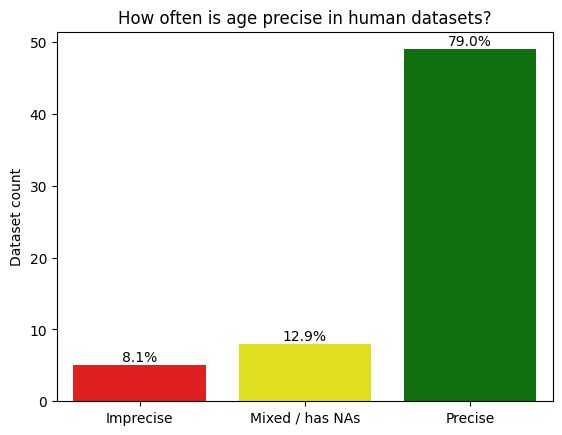

In [39]:
datasets_with_age = [dataset for dataset in human_datasets if dataset_has_age_information(dataset)]
ages_quantitative = pd.Series(list(map(is_age_precise, datasets_with_age)))
ax = sns.countplot(x=ages_quantitative, order=["Imprecise", "Mixed / has NAs", "Precise"], orient="v", palette=["red", "yellow", "green"])
plt.title("How often is age precise in human datasets?")
plt.xlabel("")
plt.ylabel("Dataset count")
add_percentages_to_countplot(ax, ages_quantitative, y_offset=0.5)

Text(0.5, 1.0, 'Age distribution in datasets where age is precise')

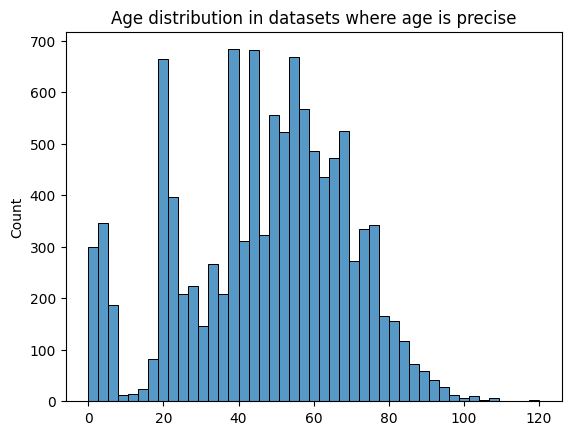

In [40]:
datasets_with_quantitative_age = [dataset for dataset in datasets_with_age if is_age_precise(dataset) == "Precise"]
quantitative_ages = list(itertools.chain.from_iterable(get_sample_ages(dataset) for dataset in datasets_with_quantitative_age))
quantitative_ages = [age if isinstance(age, float) else (age[0]+age[1])/2 for age in quantitative_ages] # Convert ranges to single numbers
sns.histplot(quantitative_ages)
plt.title("Age distribution in datasets where age is precise")

/tmp/ipykernel_2203439/2501700311.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=presence_of_tissue_in_samples, orient="v", palette=["red", "green"], order=["Absent", "Present"])


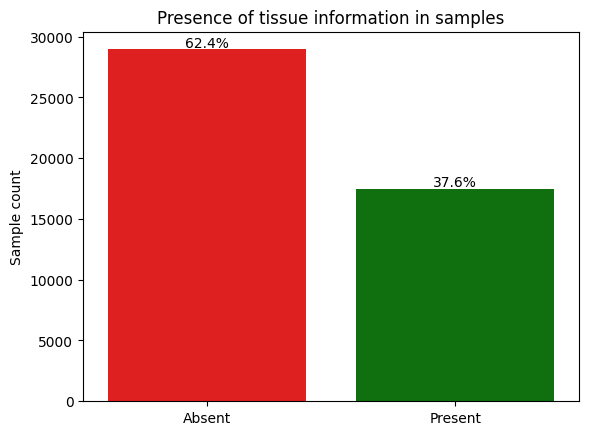

In [41]:
presence_of_tissue_in_samples = pd.Series(["Present" if "tissue" in sample.characteristics else "Absent" for sample in samples])
ax = sns.countplot(x=presence_of_tissue_in_samples, orient="v", palette=["red", "green"], order=["Absent", "Present"])
plt.title("Presence of tissue information in samples")
plt.xlabel("")
plt.ylabel("Sample count")
add_percentages_to_countplot(ax, presence_of_tissue_in_samples, y_offset=200)

/tmp/ipykernel_2203439/3411560894.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=presence_of_cell_type_in_samples, orient="v", palette=["red", "green"], order=["Absent", "Present"])


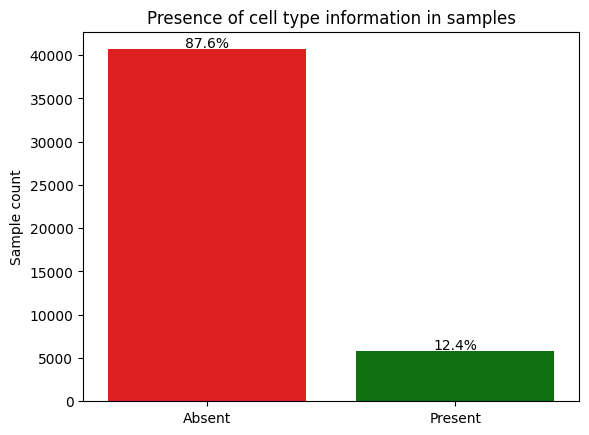

In [42]:
presence_of_cell_type_in_samples = pd.Series(["Present" if "cell type" in sample.characteristics else "Absent" for sample in samples])
ax = sns.countplot(x=presence_of_cell_type_in_samples, orient="v", palette=["red", "green"], order=["Absent", "Present"])
plt.title("Presence of cell type information in samples")
plt.xlabel("")
plt.ylabel("Sample count")
add_percentages_to_countplot(ax, presence_of_cell_type_in_samples, y_offset=200)

## Most common tissues

Text(0.5, 1.0, 'Number of samples per tissue')

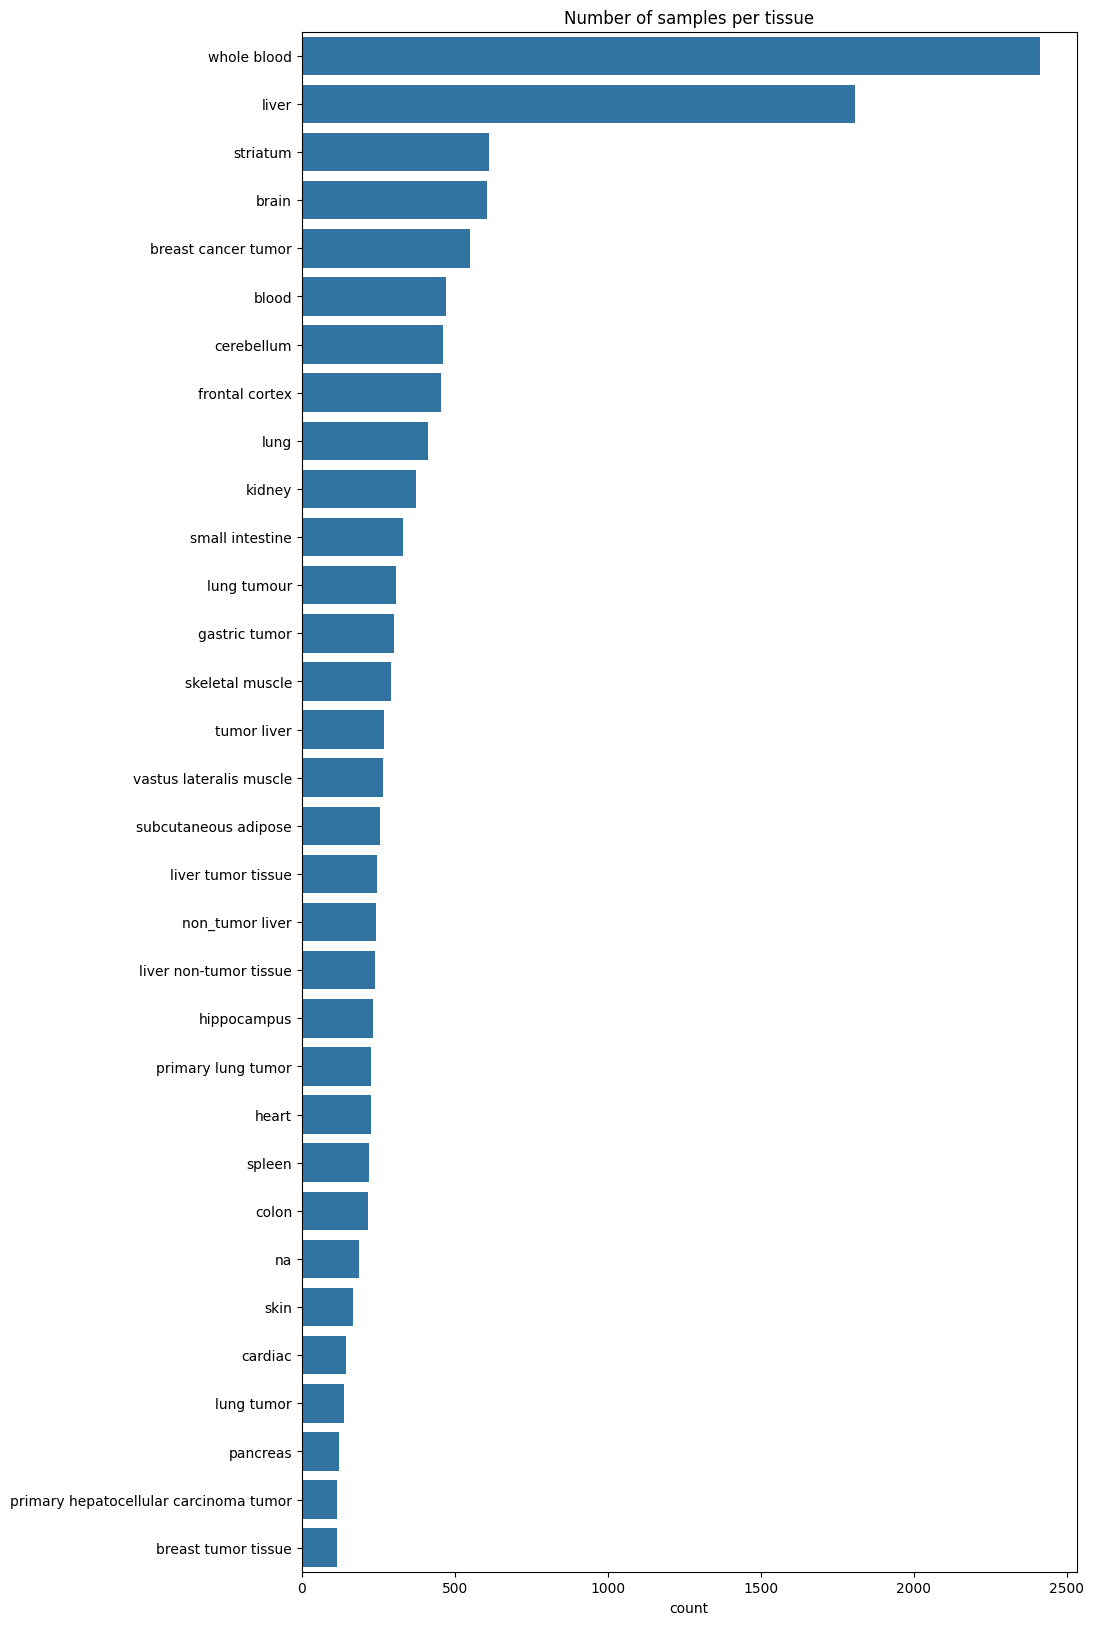

In [43]:
tissues = pd.Series([sample.characteristics["tissue"] for sample in samples if "tissue" in sample.characteristics])
tissues_processed = remove_low_frequency_levels(tissues, 100)
fig, ax = plt.subplots(figsize=(10, 20))
ax = sns.countplot(tissues_processed, ax=ax, order=tissues_processed.value_counts().index)
ax.set_title("Number of samples per tissue")

There are different names for the same tissue depending on how specific the author wanted to be. Let's try grouping the synonyms together.

The following groupings were obtained using LLama.3.3-70B with the following prompt:

Here is a list of tissue names as extracted from Gene Expression Omnibus sample records. There are different names for the same kind of tissue in the list. Group the synonymous tissue names and give the group a meaningful name. If there are no synonyms for a tissue type create a new group for each such tissue ("<tissue>": ["<tissue>"]). Do not create a category name like "Other". Make sure every item in the list is covered.

Output a JSON where the keys are the group names and the values are the synonyms in that group.

List of tissue names: \<python list of tissue names\>

In [44]:
synonym_groups = \
{
    "Fibroblasts": [
        "Dermal Fibroblast",
        "Fibroblast",
        "Fibroblasts",
        "Human Fibroblast",
        "Human embryonic lung fibroblasts",
        "Mouse embryonic fibroblast",
        "Mouse embryonic fibroblasts",
        "old fibroblasts",
        "Primary lung fibroblasts"
    ],
    "Neural Stem Cells": [
        "fetal primary NSC",
        "miNSC",
        "NSC",
        "old NSC",
        "old miNSC",
        "Primary neural stem cells"
    ],
    "Lung Cells": [
        "Lung cells",
        "mix cell types from lung"
    ],
    "Hepatocytes": [
        "hepatoma cell",
        "Hepatocyte",
        "hepatocellular carcinoma",
        "liver"
    ],
    "Mesenchymal Stromal Cells": [
        "Mesenchymal stromal cell",
        "Mesenchymal stromal cells",
        "human Mesenchymal stem cells",
        "mesenchymal stem cells"
    ],
    "Blood Cells": [
        "Bone marrow cells",
        "Bone marrow mononuclear cells",
        "Hematopoietic progenitors",
        "Hematopoietic stem cells",
        "leukocyte",
        "Peripheral mononuclear blood cell"
    ],
    "Stromal Cells": [
        "CD45-PECAM1+ thymic stroma cells",
        "CD45-PDGFRA+ thymic stroma cells",
        "CD45- thymic stroma cells",
        "Normal human primary prostate stromal cells",
        "stroma cells"
    ],
    "Epithelial Cells": [
        "Conjunctival epithelial cell",
        "corneal epithelial cell"
    ],
    "Muscle Cells": [
        "immortalized mouse myoblast",
        "muscle stem",
        "Pax7+ stem cells"
    ],
    "Immune Cells": [
        "Alveolar Macrophages",
        "B lymphoblastoid",
        "B lymphoblastoid, mouse embryonic stem cell",
        "primary T-cells",
        "T lymphocyte cells"
    ],
    "Yeast Cells": [
        "yeast cells"
    ],
    "Cell Culture": [
        "cell culture",
        "mixed cell culture",
        "mixture"
    ],
    "Brain Cells": [
        "astrocytes",
        "brain",
        "brain cells",
        "microglia",
        "neurons",
        "total brain cells"
    ],
    "Embryonic Stem Cells": [
        "mouse embryonic stem cell"
    ],
    "Podocytes": [
        "podocytes"
    ],
    "Leydig Cells": [
        "Leydig cells"
    ],
    "Endothelial Cells": [
        "Endothelial cells isolation(CD31 positive selection)"
    ],
    "Human Neuronal Cells": [
        "Human nueronal cells"
    ],
    "EPC": [
        "EPC"
    ],
    "NPC": [
        "NPC"
    ],
    "FAPs": [
        "FAPs"
    ],
    "MEF": [
        "MEF",
        "MEFs"
    ],
    "Human Embryonic Kidney": [
        "human embryonic kidney"
    ],
    "Dental Pulp Cell": [
        "Dental pulp cell"
    ],
    "Tissue Dissociated Cells": [
        "tissue dissociated cells"
    ],
    "Reprogramming Intermediate": [
        "Reprogramming intermediate"
    ],
    "Etoposide-induced Senescent Cells": [
        "Etoposide-induced senescent (ETIS) cells"
    ],
    "Carcinoma Cells": [
        "Carcinoma, derived from the metastatic site, bone of a prostate cancer patient",
        "Grade IV, adenocarcinoma, derived from the metastatic site, brain of a prostate cancer patient"
    ]
}

tissue_to_group_mapping = {tissue: group for group, tissue_list in synonym_groups.items() for tissue in tissue_list}

In [45]:
mapped_tissues = [tissue_to_group_mapping[tissue] if tissue in tissue_to_group_mapping else tissue for tissue in tissues]

Text(0.5, 1.0, 'Number of samples per tissue (synonyms grouped)')

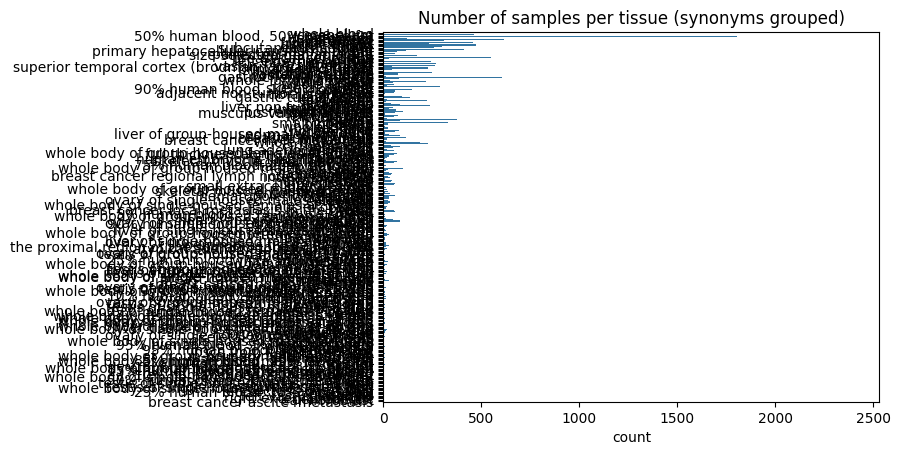

In [46]:
ax = sns.countplot(mapped_tissues)
ax.set_title("Number of samples per tissue (synonyms grouped)")

## Most common cell types

Text(0.5, 1.0, 'Number of samples per cell type')

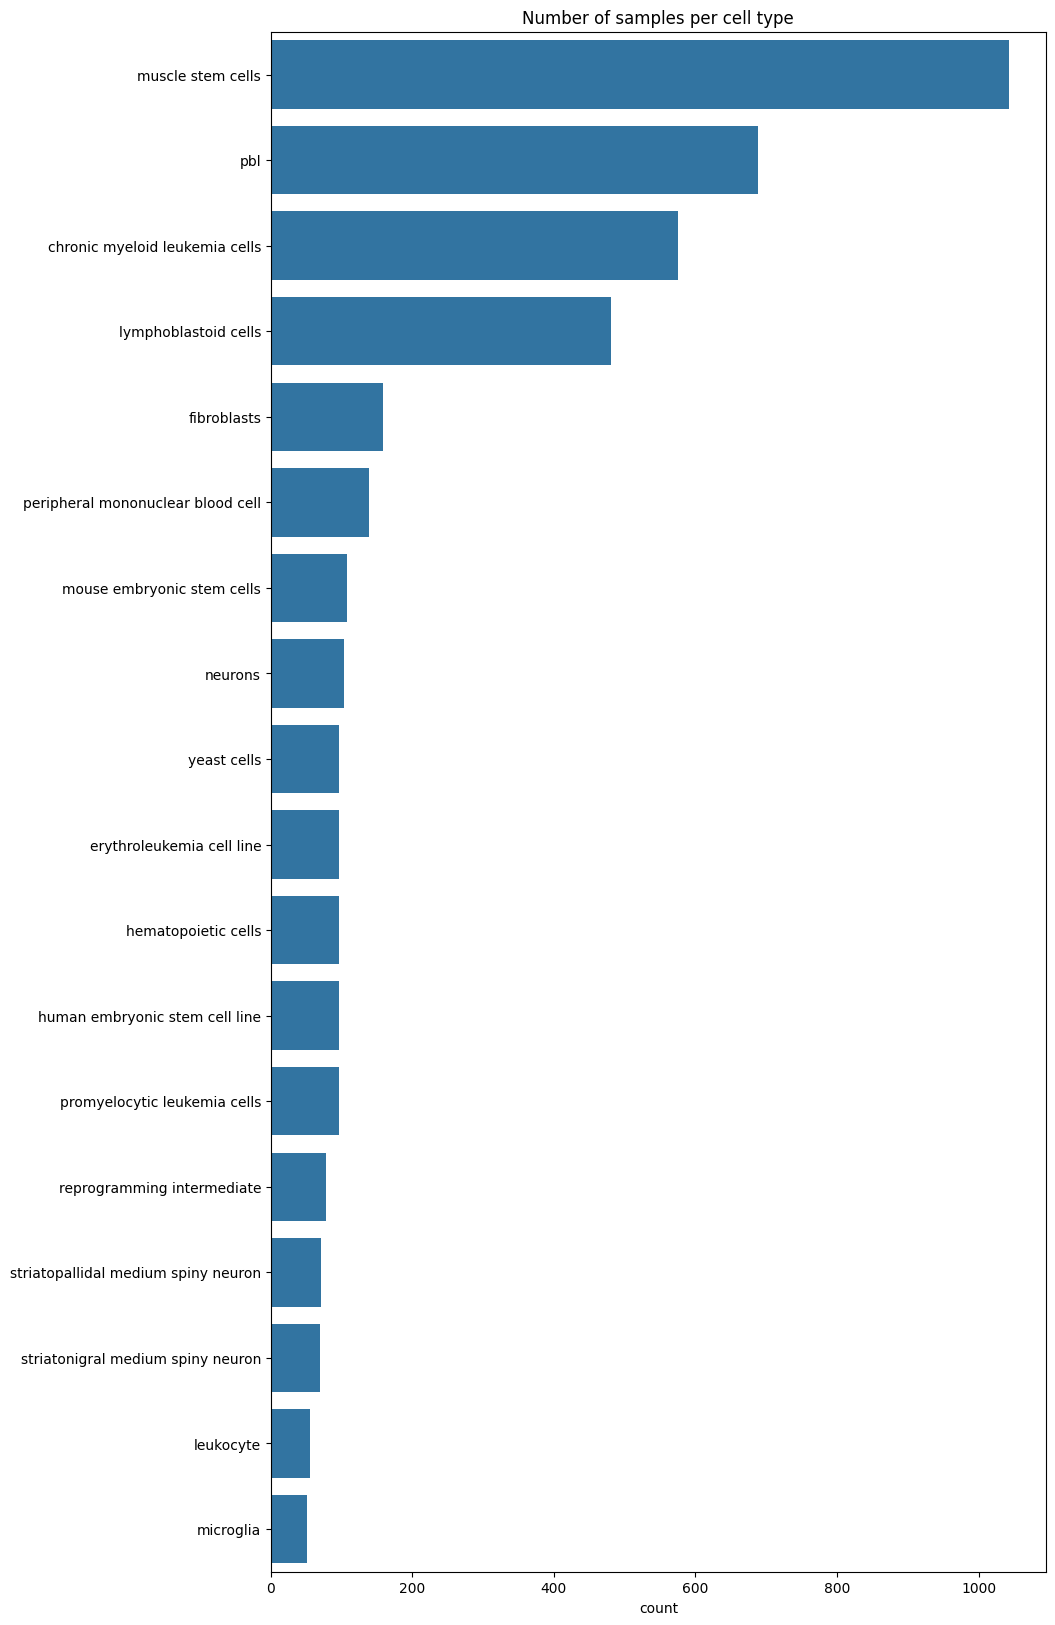

In [47]:
cell_types = pd.Series([sample.characteristics["cell type"] for sample in samples if "cell type" in sample.characteristics])
cell_types_processed = remove_low_frequency_levels(cell_types, 50)
fig, ax = plt.subplots(figsize=(10, 20))
ax = sns.countplot(cell_types_processed, ax=ax, order=cell_types_processed.value_counts().index)
ax.set_title("Number of samples per cell type")

There are synonyms here as well.

As a side note, let's see if most samples contain either the tissue type or cell type as both are indicative of the tissue being studied. 

In [48]:
contains_tissue_or_cell_type = [sample for sample in samples if "tissue" in sample.characteristics or "cell type" in sample.characteristics]
n_samples = len(samples)
n_contains = len(contains_tissue_or_cell_type)
print(f"{n_contains}/{n_samples} ({n_contains / n_samples * 100}%) contain tissue information")

22245/46438 (47.90257978379775%) contain tissue information


## Values of other characteristics fields

Time

In [49]:
time_values = [sample.characteristics["time"] for sample in samples if "time" in sample.characteristics]
time_values += [sample.characteristics["time point"] for sample in samples if "time point" in sample.characteristics]
for time in set(time_values):
    print(time)


control
1 hour
d0
isolation after 11 days of culture
4hrs post exercise
72 h
day 5
d0 (1st day of adulthood)
day 10
isolation after 7 days of culture
young adult (d1 of adulthood)
2 hours
isolation after 11 days after transfection
24 hours
isolation after 21 days of culture
6 hours
7 hours
basal
3 hours
isolation after 14 days of culture
day 0
2hrs after the indicated surgery


Age

In [50]:
age_keys = set([key for key in characteristics_keys if "age" in key.split(" ")])
age_values = []
for age_key in age_keys:
    age_values += [sample.characteristics[age_key] for sample in samples if age_key in sample.characteristics]
print("Keys:", age_keys)
for age_value in set(age_values):
    print(age_value)

Keys: {'age', 'age group', 'age (years)', 'age at recruitment 1dp', 'age (yr)', 'age (y)', 'age at diag', 'age category', 'age at diagnosis', 'age at death', 'age (yrs)', 'age at surgery'}
52.8
94
42.6
74.37646
42.02875
32.8
74.05339
4w
55.1
37.9
32.0
70.6
77.9
60.5
78w
48 years
23.1
104  years old
26 years old
22 years
50.53251
3yr0mos
23.7
50
2yr3mos
47 years
57.1
57.40999
34.9
80.78
80.21902
51.3
88
70.56
73.9
57.5
63.154
p38
69.77
67.62
49.6
29.6
30.8
68.87
21.1
63 years
0.42
61.86
66.46
40 days
38.85558
28.1
49.83984
31 years old
24 years old
82.36
80.76
young (2-month-old)
67 years
38.4
29.8
38.7
60.7
67.29
73
35.5
78.28063
18-month old
16
37.6
59.2
63.54
12.6 weeks
66.02053
42.2
66.26421
51
53.3
42.8
6.7 years
61.7
12.3 years
aged (24-month-old)
66.00137
78 weeks
81.17
73.2
74.6
44.9
38.2
31.1
73.26
84.48
87.11
74.16
27.2
56.1
12 years
28 months
49.3
44.8
24 years
35.2
61.59
33.8
55.96441
38.6
75.58
49.9
75.03
62.5
86 wk
24 mo
31.4
40.0
20.6
72.55
68.18891
63
12.1 years
77.18
48

## Parsing age fields

Age is usually represented here as a number or range followed by a unit, or just a number.
However there are excpetions to this rule, for example ">60 years old", and they have to be handled differently.
There are also non-numerical descriptions such as Young, Middle and Old which cannot be converted into numbers.

In [51]:
import re
INF_AGE = 999
MIN_AGE = 0


def normalize_to_years(value, unit):
    """Converts age to years based on the unit."""
    unit = unit.lower()
    if unit in ['year', 'years', 'yr', 'yrs', 'y']:
        return float(value)
    elif unit in ['month', 'months', 'mo', 'mos']:
        return float(value) / 12.0
    elif unit in ['week', 'weeks', 'wks', 'wk', 'w']:
        return float(value) / 52.0
    elif unit in ['day', 'days', 'd']:
        return float(value) / 365.0
    return None  # Should not happen if regex is correct


def extract_age(age_str: str):
    """
    Extratcts age in years or a range from a piece of text 
    stating the age or age group.
    If the age cannot be determined, the function returns null.

    :param age_str: Text from which to extract the age
    :returns: A single number containing the age or a pair if a range was detected.
    """
    age_str = str(age_str).lower().strip()  # Normalize text

    if is_number(age_str):
        return float(age_str)  # assume age is in years

    is_age_range, age_range = try_extract_age_range(age_str)
    if is_age_range:
        return age_range

    # Handle 110+
    is_age_plus, age_range = try_extract_age_plus(age_str)
    if is_age_plus:
        return age_range

    # Handle >60
    is_greater_than_age, age_range = try_extract_greater_than_age(age_str)
    if is_greater_than_age:
        return age_range
    
    # Handle <60
    is_less_than_age, age_range = try_extract_less_than_age(age_str)
    if is_less_than_age:
        return age_range

    is_age_plus_unit, age = try_extract_age_plus_unit(age_str)
    if is_age_plus_unit:
        return age

    
    return None


def try_extract_age_range(age_str: str):
    match = re.search(
        r'(\d+\.?\d*)\s*-\s*(\d+\.?\d*)\s*(year|yr|month|mo|week|wk|w|day|d)?s?\s*(old)?', age_str)
    if not match:
        return False, None
    val1 = float(match.group(1))
    val2 = float(match.group(2))
    unit = match.group(3)
    if unit:
        return True, (normalize_to_years(val1, unit), normalize_to_years(val2, unit))
    else:
        return True, (val1, val2)  # Assume years


def try_extract_age_plus_unit(age_str: str):
    match = re.search(
        r'(\d+\.?\d*)\s*-?\s*(year|yr|month|mo|week|wk|w|day|d)s?\s*-?\s*(old)?', age_str)
    if not match:
        return False, None
    if match:
        value = float(match.group(1))
        unit = match.group(2)
        return True, normalize_to_years(value, unit)


def try_extract_age_plus(age_str: str):
    """
    Tries to extract ages like 110+ out of the text.
    """
    match = re.search(r'(\d+)\+', age_str)
    if not match:
        return False, None
    if match:
        return True, (float(match.group(1)), INF_AGE)


def try_extract_greater_than_age(age_str: str):
    """
    Tries to extract ages like >20 out of the text.
    """
    match = re.search(r'\>(\d+)', age_str)
    if not match:
        return False, None
    if match:
        return True, (float(match.group(1)), INF_AGE)


def try_extract_less_than_age(age_str: str):
    """
    Tries to extract ages like <20 out of the text.
    """
    match = re.search(r'\<(\d+)', age_str)
    if not match:
        return False, None
    if match:
        return True, (MIN_AGE, float(match.group(1)))


def is_number(text):
    try:
        float(text)
        return True
    except:
        return False

In [52]:
for age in set(age_values):
    print(age, extract_age(age))

52.8 52.8
94 94.0
42.6 42.6
74.37646 74.37646
42.02875 42.02875
32.8 32.8
74.05339 74.05339
4w 0.07692307692307693
55.1 55.1
37.9 37.9
32.0 32.0
70.6 70.6
77.9 77.9
60.5 60.5
78w 1.5
48 years 48.0
23.1 23.1
104  years old 104.0
26 years old 26.0
22 years 22.0
50.53251 50.53251
3yr0mos 3.0
23.7 23.7
50 50.0
2yr3mos 2.0
47 years 47.0
57.1 57.1
57.40999 57.40999
34.9 34.9
80.78 80.78
80.21902 80.21902
51.3 51.3
88 88.0
70.56 70.56
73.9 73.9
57.5 57.5
63.154 63.154
p38 None
69.77 69.77
67.62 67.62
49.6 49.6
29.6 29.6
30.8 30.8
68.87 68.87
21.1 21.1
63 years 63.0
0.42 0.42
61.86 61.86
66.46 66.46
40 days 0.1095890410958904
38.85558 38.85558
28.1 28.1
49.83984 49.83984
31 years old 31.0
24 years old 24.0
82.36 82.36
80.76 80.76
young (2-month-old) 0.16666666666666666
67 years 67.0
38.4 38.4
29.8 29.8
38.7 38.7
60.7 60.7
67.29 67.29
73 73.0
35.5 35.5
78.28063 78.28063
18-month old 1.5
16 16.0
37.6 37.6
59.2 59.2
63.54 63.54
12.6 weeks 0.2423076923076923
66.02053 66.02053
42.2 42.2
66.26421 66

## Parsing sex and gender

<Axes: xlabel='count'>

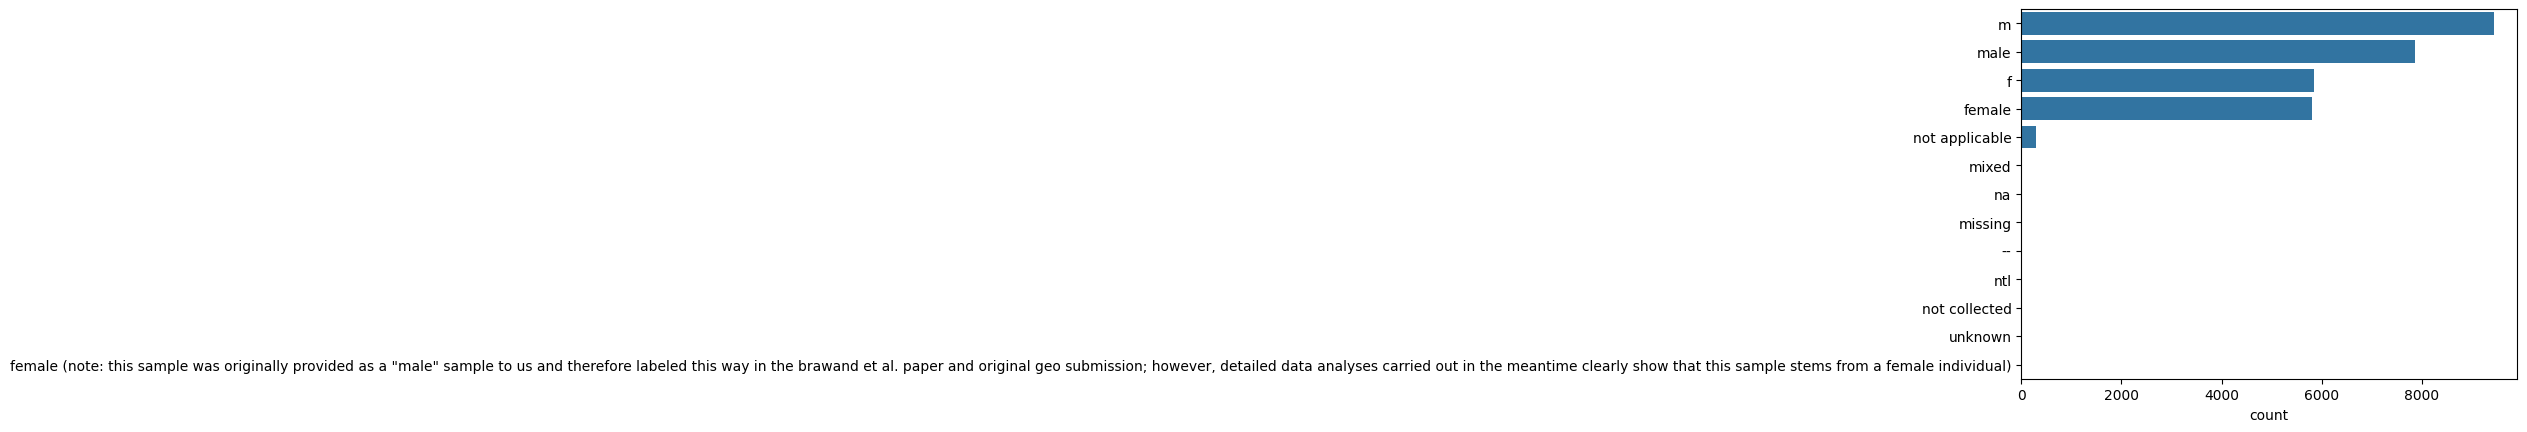

In [53]:
sex_gender_values = [sample.characteristics["sex"].strip().lower() for sample in samples if "sex" in sample.characteristics]
sex_gender_values += [sample.characteristics["gender"].strip().lower() for sample in samples if "gender" in sample.characteristics]
sex_gender_values = pd.Series(sex_gender_values)
sns.countplot(sex_gender_values, order=sex_gender_values.value_counts().index)

Parsing only the male, m, female, and f values seems to be sufficient.

<Axes: title={'center': 'Gender distribution (in samples where it is available)'}, xlabel='count'>

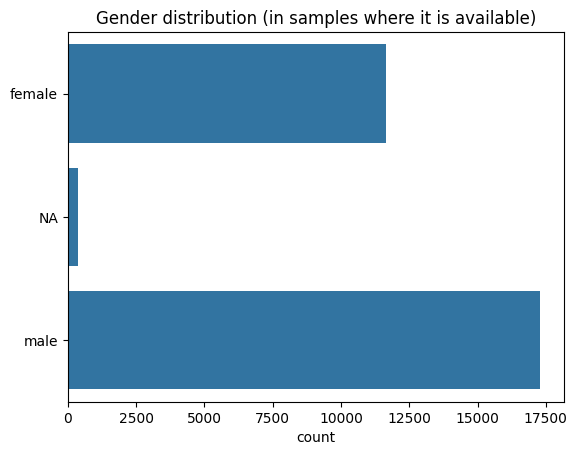

In [ ]:
from src.parsing.gender.get_gender import get_gender
genders = []
for sample in samples:
    if not "sex" in sample.characteristics and not "gender" in sample.characteristics:
        continue
    genders.append(get_gender(sample) or "NA")

plt.title("Gender distribution (in samples where it is available)")
sns.countplot(genders)

## Grouping tissues

In [ ]:
import scispacy.linking_utils

def create_without_ner(knowledge_base="umls"):
    """
    Returns a scispacy NLP pipeline for entity linking with the UMLS database.
    """
    nlp = spacy.load("en_core_sci_md")

    # This line takes a while, because we have to download ~1GB of data
    # and load a large JSON file (the knowledge base). Be patient!
    # Thankfully it should be faster after the first time you use it, because
    # the downloads are cached.
    # NOTE: The resolve_abbreviations parameter is optional, and requires that
    # the AbbreviationDetector pipe has already been added to the pipeline. Adding
    # the AbbreviationDetector pipe and setting resolve_abbreviations to True means
    # that linking will only be performed on the long form of abbreviations.
    nlp.add_pipe("scispacy_linker", config={"resolve_abbreviations": True, "linker_name": knowledge_base})
    return nlp

def create_entity_linking_pipeline_with_ner(knowledge_base="umls"):
    """
    Returns a scispacy NLP pipeline for entity linking with the UMLS database
    that also performs named entity recognition.
    """
    nlp = spacy.load("en_ner_bionlp13cg_md")

    # This line takes a while, because we have to download ~1GB of data
    # and load a large JSON file (the knowledge base). Be patient!
    # Thankfully it should be faster after the first time you use it, because
    # the downloads are cached.
    # NOTE: The resolve_abbreviations parameter is optional, and requires that
    # the AbbreviationDetector pipe has already been added to the pipeline. Adding
    # the AbbreviationDetector pipe and setting resolve_abbreviations to True means
    # that linking will only be performed on the long form of abbreviations.
    nlp.add_pipe("scispacy_linker", config={"resolve_abbreviations": True, "linker_name": knowledge_base})
    return nlp


def link_entities(nlp, document: str) -> List[scispacy.linking_utils.Entity]:
    """
    Links entities in the document to the knowledge base of the scicpacy pipeline 
    and returns the canonical names and match scores.

    :param nlp: Scispacy NLP pipeline for entity linking and named entity
    recognition (see create_entity_linking_pipeline).
    :param document: The document in which to link entities to UMLS.
    :returns: A list of tuples (entity, canonical_name, score, label) where:
        1. entity is the name of the entity as it appears in the text.
        2. canonical_name is the canonical name of the entity in the knowledge base.
        3. score is the score of the knowledge base match. 
        4. NER label of the entity (e.g. ORGANISM, CELL, ...) 
        If an entity does not exist in the knowledge base it will be returned as (entity, entity, -1, None).
    """
    processed_doc = nlp(document)
    linker = nlp.get_pipe("scispacy_linker")
    knowledge_base = linker.kb
    all_links = []
    for ent in processed_doc.ents:
        if not ent._.kb_ents:
            all_links.append((ent, ent, -1, ent.label_))
            continue

        concept_id, score = ent._.kb_ents[0]
        umls_entity = knowledge_base.cui_to_entity[concept_id]
        canonical_name = umls_entity.canonical_name
        entity_link = (ent, canonical_name, score, ent.label_)
        all_links.append(entity_link)
            
    return all_links

def get_canonical_name(nlp, tissue: str):
    entity_links = link_entities(nlp, tissue)
    if not entity_links:
        return (tissue, tissue, -1)

    relevant_labels = ["CELL", "TISSUE", "ORGAN", "PATHOLOGICAL_FORMATION"]
    relevant_links = list(filter(lambda link: link[3] in relevant_labels, entity_links))
    if relevant_links:
        return max(relevant_links, key=lambda link: link[2])[:3] # Return link with the highest score
    return max(entity_links, key=lambda link: link[2])[:3]


In [ ]:
nlp = create_entity_linking_pipeline_with_ner(knowledge_base="umls")

KeyboardInterrupt: 

In [ ]:

unique_tissues = list(set(tissues))
 
entity_links_ner = [get_canonical_name(nlp, tissue) for tissue in unique_tissues]
for entity, canonical_name, score in entity_links_ner:
    print ("Entity:", entity)
    print ("Score:", score)
    print ("Cannonical name:", canonical_name)
    print("------")


Entity: ovary
Score: 1.0
Cannonical name: Ovary
------
Entity: ovary
Score: 1.0
Cannonical name: Ovary
------
Entity: lung tumor
Score: 0.9999999403953552
Cannonical name: Lung Neoplasms
------
Entity: mef
Score: -1
Cannonical name: mef
------
Entity: mouse spleen
Score: 1.0
Cannonical name: Mouse Spleen
------
Entity: testis
Score: 1.0
Cannonical name: Testis
------
Entity: frontal lobe
Score: 1.0
Cannonical name: frontal lobe
------
Entity: muscle
Score: 1.0
Cannonical name: Muscle Tissue
------
Entity: brain
Score: 0.9999998807907104
Cannonical name: Brain
------
Entity: mouse fat
Score: 1.0
Cannonical name: Steatomys pratensis
------
Entity: skeletal muscle
Score: 1.0
Cannonical name: Skeletal muscle structure
------
Entity: neck
Score: -1
Cannonical name: neck
------
Entity: skeletal muscle
Score: 1.0
Cannonical name: Skeletal muscle structure
------
Entity: vastus lateralis muscle
Score: 1.0
Cannonical name: Structure of vastus lateralis muscle
------
Entity: frontal cortex
Score

### Scispacy vs LLM

In [ ]:
tissue_standardization_df_dict = {
    "entity": unique_tissues,
    "scispacy_name": [link[1] for link in entity_links_ner],
    "llm_name": [tissue_to_group_mapping[tissue] if tissue in tissue_to_group_mapping else tissue for tissue in unique_tissues]
}
tissue_naming_df = pd.DataFrame(tissue_standardization_df_dict)
pd.set_option('display.max_rows', None)
tissue_naming_df

entity  \
0                  ovary of single-housed males at 11 wph   
1                   ovary of single-housed males at 3 wph   
2                                      primary lung tumor   
3                                                     mef   
4                       25% human blood, 75% mouse spleen   
5                   testis of group-housed males at 5 wph   
6                                      frontal lobe brain   
7                                                  muscle   
8                                         nuclei of brain   
9                          90% human blood, 10% mouse fat   
10                         skeletal muscle, gastrocnemius   
11                                                   neck   
12                     skeletal muscle, iibialis anterior   
13                                vastus lateralis muscle   
14                                         frontal cortex   
15                       5% human blood, 95% mouse spleen   
16                                          gastric tumor   
17                                           normal liver   
18          whole body of single-housed females at 10 dph   
19                                                   skin   
20                                         cardiomyocytes   
21                                          healthy liver   
22                                            lung tumour   
23                 testis of single-housed males at 8 wph   
24                       breast cancer ascite  metastasis   
25                                      epithelial tissue   
26           whole body of group-housed females at 28 dph   
27                         85% human blood, 15% mouse fat   
28                                            conjunctiva   
29                                       epithelial cells   
30                                                cardiac   
31                                             fetal limb   
32                      gastric surrounding normal tissue   
33             whole body of group-housed males at 13 dph   
34                                                  liver   
35                             penumbras tissue of brains   
36                       atypical adenomatous hyperplasia   
37                       cytologically-normal lung tissue   
38                                       100% human blood   
39                                            whole liver   
40                                            limb muscle   
41                  liver of group-housed males at 14 wph   
42                       human embryonic lung fibroblasts   
43                                            hydrothorax   
44                                      posterior putamen   
45                                                   gwat   
46                                                 marrow   
47                                   brown adipose tissue   
48   the proximal region of the somatic gonad (psg) cells   
49                                    lung adenocarcinoma   
50                          ipscs from kidney fibroblasts   
51                      10% human blood, 90% mouse spleen   
52                                            fetal brain   
53                         50% human blood, 50% mouse fat   
54                 primary hepatocellular carcinoma tumor   
55                                                  ovary   
56                                            whole brain   
57                                  whole lung dissociate   
58                                          frontal brain   
59                                             peritoneum   
60                                                  aorta   
61                                      fore footpad skin   
62             whole body of group-housed males at 28 dph   
63                                            whole flies   
64                                                   pbmc   
65                       

### NER vs no NER

In [ ]:
nlp_no_ner = create_without_ner()

/home/Momir.Milutinovic/repos/pubmed-paper-exploration/.venv/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator TfidfTransformer from version 1.1.2 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/Momir.Milutinovic/repos/pubmed-paper-exploration/.venv/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator TfidfVectorizer from version 1.1.2 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [ ]:
entity_links_no_ner = [get_canonical_name(nlp_no_ner, tissue) for tissue in unique_tissues]
tissue_standardization_df_dict = {
    "entity": unique_tissues,
    "name with ner": [link[1] for link in entity_links_ner],
    "name without ner": [link[1] for link in entity_links_no_ner],
}
tissue_naming_df = pd.DataFrame(tissue_standardization_df_dict)
pd.set_option('display.max_rows', None)
tissue_naming_df

entity  \
0                  ovary of single-housed males at 11 wph   
1                   ovary of single-housed males at 3 wph   
2                                      primary lung tumor   
3                                                     mef   
4                       25% human blood, 75% mouse spleen   
5                   testis of group-housed males at 5 wph   
6                                      frontal lobe brain   
7                                                  muscle   
8                                         nuclei of brain   
9                          90% human blood, 10% mouse fat   
10                         skeletal muscle, gastrocnemius   
11                                                   neck   
12                     skeletal muscle, iibialis anterior   
13                                vastus lateralis muscle   
14                                         frontal cortex   
15                       5% human blood, 95% mouse spleen   
16                                          gastric tumor   
17                                           normal liver   
18          whole body of single-housed females at 10 dph   
19                                                   skin   
20                                         cardiomyocytes   
21                                          healthy liver   
22                                            lung tumour   
23                 testis of single-housed males at 8 wph   
24                       breast cancer ascite  metastasis   
25                                      epithelial tissue   
26           whole body of group-housed females at 28 dph   
27                         85% human blood, 15% mouse fat   
28                                            conjunctiva   
29                                       epithelial cells   
30                                                cardiac   
31                                             fetal limb   
32                      gastric surrounding normal tissue   
33             whole body of group-housed males at 13 dph   
34                                                  liver   
35                             penumbras tissue of brains   
36                       atypical adenomatous hyperplasia   
37                       cytologically-normal lung tissue   
38                                       100% human blood   
39                                            whole liver   
40                                            limb muscle   
41                  liver of group-housed males at 14 wph   
42                       human embryonic lung fibroblasts   
43                                            hydrothorax   
44                                      posterior putamen   
45                                                   gwat   
46                                                 marrow   
47                                   brown adipose tissue   
48   the proximal region of the somatic gonad (psg) cells   
49                                    lung adenocarcinoma   
50                          ipscs from kidney fibroblasts   
51                      10% human blood, 90% mouse spleen   
52                                            fetal brain   
53                         50% human blood, 50% mouse fat   
54                 primary hepatocellular carcinoma tumor   
55                                                  ovary   
56                                            whole brain   
57                                  whole lung dissociate   
58                                          frontal brain   
59                                             peritoneum   
60                                                  aorta   
61                                      fore footpad skin   
62             whole body of group-housed males at 28 dph   
63                                            whole flies   
64                                                   pbmc   
65                       

## Parsing cell types

In [ ]:
cell_types = [sample.characteristics["cell type"] for sample in samples if "cell type" in sample.characteristics]
unique_cell_types = list(set(cell_types))

In [ ]:
entity_links_cell_types = [get_canonical_name(nlp, cell_type) for cell_type in unique_cell_types]
cell_standardization_df_dict = {
    "Entity": unique_cell_types,
    "Name with NER": [link[1] for link in entity_links_cell_types],
}
cell_naming_df = pd.DataFrame(cell_standardization_df_dict)
pd.set_option('display.max_rows', None)
cell_naming_df

Entity  \
0                                                                                               mef   
1                                                                  dermal fibroblasts, immortalized   
2                                                                                              mono   
3                                                                                 bone marrow cells   
4                                                         megakaryocitic erythroyd progenitor (mep)   
5                                                                         g-mdsc purified from pbmc   
6                                                                                     neonatal cd4+   
7                                                                                              mefs   
8                                                                             liver carcinoma cells   
9                                                                                         astrocyte   
10                                                                            human skin fibroblast   
11                                                                                     cell culture   
12   grade iv, adenocarcinoma, derived from the metastatic site, brain of a prostate cancer patient   
13                                                                               primary astrocytes   
14                                                                                       astrocytes   
15                                                                                       erya cells   
16                                                                                       fibroblast   
17                                                                                            liver   
18                                                                                      cd 8 t cell   
19                                                                         mix cell types from lung   
20                                                                 human embryonic lung fibroblasts   
21                                                                       reprogramming intermediate   
22                                                                    bone marrow mononuclear cells   
23                                                                                            minsc   
24                                                                                    hepatoma cell   
25                                                                         tissue dissociated cells   
26                                                           human umbilical vein endothelial cells   
27                                                                         whole body mated females   
28                                                                 es-derived lung fibroblast cells   
29                                                    col2a1+ growth plate chondrocytes (tdtomato+)   
30                                                                             human nueronal cells   
31                                                                                     granulocytes   
32                                                                                     stroma cells   
33                                                                                             pbmc   
34                                                                peripheral mononuclear blood cell   
35                                                                                  primary t-cells   
36                                                                                        monocytes   
37                                                                                         12m cd4+   
38                                                                        in

## Comparison between the Gilda-scispacy combined parser and the purely scispacy parser

In [ ]:
from src.tissue_and_cell_type_standardization.get_standard_name import get_standard_name
from src.tissue_and_cell_type_standardization.is_mesh_term_in_anatomy_or_disease import build_mesh_lookup
mesh_lookup = build_mesh_lookup("desc2025.xml")
standardization_resources = StandardizationResources(mesh_lookup, nlp)

Building MeSH lookup from 'desc2025.xml'...
Lookup built successfully. Found 265680 unique terms.


### Tissue names

In [ ]:
tissue_naming_df["gilda_name"] = tissue_naming_df["entity"].apply(get_standard_name, resources=standardization_resources)
tissue_naming_df[["entity", "name with ner", "gilda_name"]]

entity  \
0                  ovary of single-housed males at 11 wph   
1                   ovary of single-housed males at 3 wph   
2                                      primary lung tumor   
3                                                     mef   
4                       25% human blood, 75% mouse spleen   
5                   testis of group-housed males at 5 wph   
6                                      frontal lobe brain   
7                                                  muscle   
8                                         nuclei of brain   
9                          90% human blood, 10% mouse fat   
10                         skeletal muscle, gastrocnemius   
11                                                   neck   
12                     skeletal muscle, iibialis anterior   
13                                vastus lateralis muscle   
14                                         frontal cortex   
15                       5% human blood, 95% mouse spleen   
16                                          gastric tumor   
17                                           normal liver   
18          whole body of single-housed females at 10 dph   
19                                                   skin   
20                                         cardiomyocytes   
21                                          healthy liver   
22                                            lung tumour   
23                 testis of single-housed males at 8 wph   
24                       breast cancer ascite  metastasis   
25                                      epithelial tissue   
26           whole body of group-housed females at 28 dph   
27                         85% human blood, 15% mouse fat   
28                                            conjunctiva   
29                                       epithelial cells   
30                                                cardiac   
31                                             fetal limb   
32                      gastric surrounding normal tissue   
33             whole body of group-housed males at 13 dph   
34                                                  liver   
35                             penumbras tissue of brains   
36                       atypical adenomatous hyperplasia   
37                       cytologically-normal lung tissue   
38                                       100% human blood   
39                                            whole liver   
40                                            limb muscle   
41                  liver of group-housed males at 14 wph   
42                       human embryonic lung fibroblasts   
43                                            hydrothorax   
44                                      posterior putamen   
45                                                   gwat   
46                                                 marrow   
47                                   brown adipose tissue   
48   the proximal region of the somatic gonad (psg) cells   
49                                    lung adenocarcinoma   
50                          ipscs from kidney fibroblasts   
51                      10% human blood, 90% mouse spleen   
52                                            fetal brain   
53                         50% human blood, 50% mouse fat   
54                 primary hepatocellular carcinoma tumor   
55                                                  ovary   
56                                            whole brain   
57                                  whole lung dissociate   
58                                          frontal brain   
59                                             peritoneum   
60                                                  aorta   
61                                      fore footpad skin   
62             whole body of group-housed males at 28 dph   
63                                            whole flies   
64                                                   pbmc   
65                       

In [ ]:
cell_naming_df["gilda_name"] = cell_naming_df["Entity"].apply(get_standard_name, resources=standardization_resources)
cell_naming_df["gilda_name"] = cell_naming_df["gilda_name"].fillna(cell_naming_df["Entity"])
cell_naming_df[["Entity", "Name with NER", "gilda_name"]]

Entity  \
0                                                                                               mef   
1                                                                  dermal fibroblasts, immortalized   
2                                                                                              mono   
3                                                                                 bone marrow cells   
4                                                         megakaryocitic erythroyd progenitor (mep)   
5                                                                         g-mdsc purified from pbmc   
6                                                                                     neonatal cd4+   
7                                                                                              mefs   
8                                                                             liver carcinoma cells   
9                                                                                         astrocyte   
10                                                                            human skin fibroblast   
11                                                                                     cell culture   
12   grade iv, adenocarcinoma, derived from the metastatic site, brain of a prostate cancer patient   
13                                                                               primary astrocytes   
14                                                                                       astrocytes   
15                                                                                       erya cells   
16                                                                                       fibroblast   
17                                                                                            liver   
18                                                                                      cd 8 t cell   
19                                                                         mix cell types from lung   
20                                                                 human embryonic lung fibroblasts   
21                                                                       reprogramming intermediate   
22                                                                    bone marrow mononuclear cells   
23                                                                                            minsc   
24                                                                                    hepatoma cell   
25                                                                         tissue dissociated cells   
26                                                           human umbilical vein endothelial cells   
27                                                                         whole body mated females   
28                                                                 es-derived lung fibroblast cells   
29                                                    col2a1+ growth plate chondrocytes (tdtomato+)   
30                                                                             human nueronal cells   
31                                                                                     granulocytes   
32                                                                                     stroma cells   
33                                                                                             pbmc   
34                                                                peripheral mononuclear blood cell   
35                                                                                  primary t-cells   
36                                                                                        monocytes   
37                                                                                         12m cd4+   
38                                                                        in

# Filtering datasets

## Retrieve by age range

In [ ]:


def do_ranges_overlap(range1: Tuple[float, float], range2: Tuple[float, float]) -> bool:
    return range1[0] <= range2[1] and range2[0] <= range1[1]


def is_sample_in_age_range(sample: GEOSample, age_range: Tuple[float, float]) -> bool:
    """
    Returns true if a sample's age falls into the age range (inclusive).

    :param sample: GEO sample whose age to check.
    :param age_range: Age range (from, to).
    :return: True if age is in range, false if it is not. If the
    sample does not have an age key, the function returns false.
    """
    age = sample.characteristics.get("age") or sample.characteristics.get(
        "age (yr)") or sample.characteristics.get("age (years)")
    if not age:
        return False
    age = extract_age(age)

    if isinstance(age, float):
        return age_range[0] < age < age_range[1]
    elif isinstance(age, Tuple):
        return do_ranges_overlap(age, age_range)
    elif age is None:
        return False # Cannot compare qualitative ages
    else:
        raise ValueError(f"Extracted age is of unexpected type: {type(age)}")


def dataset_has_sample_in_age_range(dataset: GEODataset, age_range: Tuple[float, float]) -> float:
    """
    Returns true if a dataset contains a sample whose age
    falls into the age range (inclusive).

    :param dataset: Dataset in which to check if it contains a sample
    of the desired age.
    :param age_range: Age range (from, to).
    :return: True if the sample contains a sample whose age is in the
    given age range, otherwise False.
    """
    return any(
        [is_sample_in_age_range(sample, age_range)
         for sample in dataset.samples]
    )


def filter_by_age_range(datasets: List[GEODataset], age_range: Tuple[float, float]):
    """
    Retrieves datasets that have samples whose age falls into the age range (inclusive).

    :param datasets: List of GEO Datasests/Series to search by age.
    :age_range: Tuple containing the age range to search for (from, to).
    :return: List of GEO datasets which contain samples that fall into the
    desired age range.
    """
    return list(filter(lambda d: dataset_has_sample_in_age_range(d, age_range), datasets))

In [ ]:
for d in filter_by_age_range(datasets, (18, 30)):
    print(d.id)


GSE133747
GSE30352
GSE76427
GSE136831
GSE226636
GSE17612
GSE275442
GSE109816
GSE116250
GSE201118
GSE212109
GSE235717
GSE125105
GSE130991
GSE242202
GSE165192
GSE80417
GSE53890
GSE178824
GSE164056
GSE113957
GSE253773
GSE182786
GSE84727
GSE120221
GSE167523
GSE147221
GSE152026
GSE42861
GSE233087
GSE59065
GSE30337
GSE110554
GSE202601
GSE21935
GSE87571
GSE121893
GSE80672


## Filter by presence of characteristic

In [ ]:
def filter_by_has_characteristic(datasets: List[GEODataset], characteristic: List[str]):
    """
    Retrieves datasets that contain a sample that for which the given characteristic
    is specified.

    :param datasets: List of datasets to filter.
    :param characteristic: The characteristic the samples must have.
    :return: List of datasets which contain a sample that has the specified charcteristic.
    """
    return list(filter(
        lambda dataset: any(
            [characteristic in sample.characteristics for sample in dataset.samples]
        ),
        datasets
    ))

Let's see which datasets have sarcopenia status specified.

In [ ]:
sarcopenia_datasets = filter_by_has_characteristic(datasets, "sarcopenia status")
for dataset in sarcopenia_datasets:
    print(dataset.id)
    print(dataset)

GSE111017
Study of sarcopenia in human muscle biopsies of elderly individuals
Expression profiling by high throughput sequencing
Homo sapiens
GSE111016
Study of sarcopenia in human muscle biopsies of elderly individuals, Singapore Sarcopenia Study
Expression profiling by high throughput sequencing
Purpose: The main goal of this study is to compare skeletal muscle transcriptome profilings derived from sarcopenic versus healthy subjects.
Homo sapiens
20 muscle biopsies from healthy subjects and 20 muscle biopsies from sarcopenic subjects.


Next, we will check out the composition of the samples.

In [ ]:
def extract_characteristic_values(samples: List[GEOSample], characteristic: str):
    return[sample.characteristics[characteristic] for sample in samples if characteristic in sample.characteristics]


In [ ]:
sarcopenia_samples = [sample for dataset in sarcopenia_datasets for sample in dataset.samples]
sarcopenia_samples = list(set(sarcopenia_samples)) # We need to remove duplicates because the first dataset is a superseries containing the second series
sarcopenia_statuses = extract_characteristic_values(sarcopenia_samples, "sarcopenia status")
sarcopenia_sample_sexes = extract_characteristic_values(sarcopenia_samples, "Sex")
sarcopenia_statuses = pd.Series(sarcopenia_statuses)
sarcopenia_sample_sexes = pd.Series(sarcopenia_sample_sexes)
print ("Sarcopenia status of the samples in the sarcopenia study")
print(sarcopenia_statuses.value_counts())
print ("Sexes of the samples in the sarcopenia study")
print(sarcopenia_sample_sexes.value_counts())

Sarcopenia status of the samples in the sarcopenia study
no     86
yes    33
Name: count, dtype: int64
Sexes of the samples in the sarcopenia study
Series([], Name: count, dtype: int64)


## Filter by publication date

In [ ]:
def filter_by_publication_date(datasets: List, date_range: Tuple[datetime.datetime, datetime.datetime]):
    return filter(lambda d: date_range[0] <= d.publication_date <= date_range[1], datasets)

In [ ]:
for dataset in filter_by_publication_date(datasets, (datetime.datetime(2020, 1, 1), datetime.datetime(2020, 12, 31))):
    print(dataset.id)
    print(dataset)

GSE163558
Transcriptional heterogeneity in primary and metastatic gastric cancer revealed using single-cell RNA sequencing
Expression profiling by high throughput sequencing
Deciphering intra- and inter-tumoral heterogeneity is essential for understanding gastric cancer (GC) biology and identifying effective therapeutic targets. We used single-cell RNA sequencing (scRNA-seq) to reveal the transcriptional heterogeneity of diverse cells within primary and metastatic GC and their roles in disease progression.
Homo sapiens
We performed unbiased scRNA-seq analysis of 42,968 cells from 10 fresh human tissue samples from six patients. Primary tumor and adjacent non-tumoral samples and six metastases from different organs or tissues (liver, peritoneum, ovary, lymph node) were evaluated. Validation experiments were performed using histological assays and bulk transcriptomic datasets.
GSE155062
Enhancer-associated H3K4 methylation safeguards in vitro germline competence [ChIP-seq 1]
Genome bindi

# Parsed tissue and cell type breakdown

In [ ]:
tissues_standardized_human = pd.Series([
    get_standard_name(sample.characteristics["tissue"], standardization_resources) or sample.characteristics["tissue"]
    for dataset in human_datasets for sample in dataset.samples if "tissue" in sample.characteristics
])
tissues_standardized_mice = pd.Series([
    get_standard_name(sample.characteristics["tissue"], standardization_resources) or sample.characteristics["tissue"]

    for dataset in mice_datasets for sample in dataset.samples if "tissue" in sample.characteristics
])
cell_types_standardized_human = pd.Series([
    get_standard_name(sample.characteristics["cell type"], standardization_resources) or sample.characteristics["cell type"]

    for dataset in human_datasets for sample in dataset.samples if "cell type" in sample.characteristics
])
cell_types_standardized_mice = pd.Series([
    get_standard_name(sample.characteristics["cell type"], standardization_resources) or sample.characteristics["cell type"]

    for dataset in mice_datasets for sample in dataset.samples if "cell type" in sample.characteristics
])

In [ ]:
sum(1 if "tissue" in sample.characteristics else 0 for dataset in (human_datasets + mice_datasets) for sample in dataset.samples)

15638

Total unique: 75


Text(0.5, 0, 'Sample count')

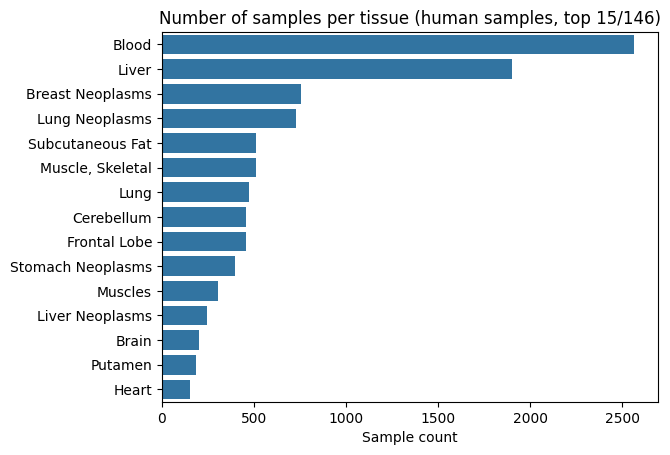

In [ ]:
reduced_tissues_human = remove_low_frequency_levels(tissues_standardized_human, 145)
print(f"Total unique: {len(tissues_standardized_human.value_counts().index)}")
sns.countplot(reduced_tissues_human, order=reduced_tissues_human.value_counts().index)
plt.title("Number of samples per tissue (human samples, top 15/146)")
plt.xlabel("Sample count")

Total unique: 56


Text(0.5, 0, 'Sample count')

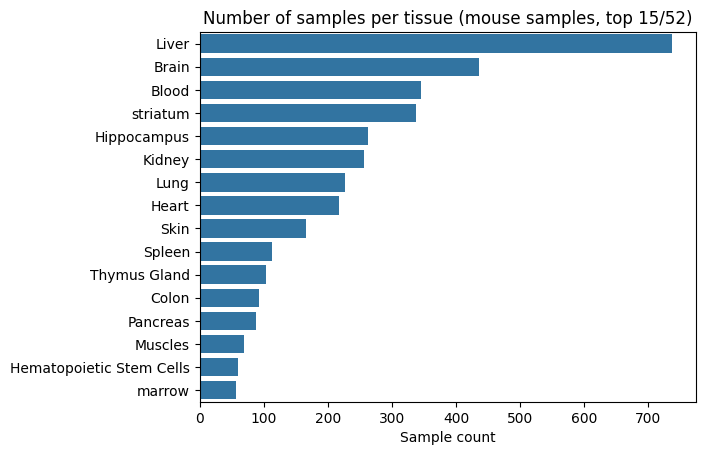

In [ ]:
reduced_tissues_mice = remove_low_frequency_levels(tissues_standardized_mice, 57)
sns.countplot(reduced_tissues_mice, order=reduced_tissues_mice.value_counts().index)
print(f"Total unique: {len(tissues_standardized_mice.value_counts().index)}")
plt.title("Number of samples per tissue (mouse samples, top 15/52)")
plt.xlabel("Sample count")

Total unique: 56


Text(0.5, 0, 'Sample count')

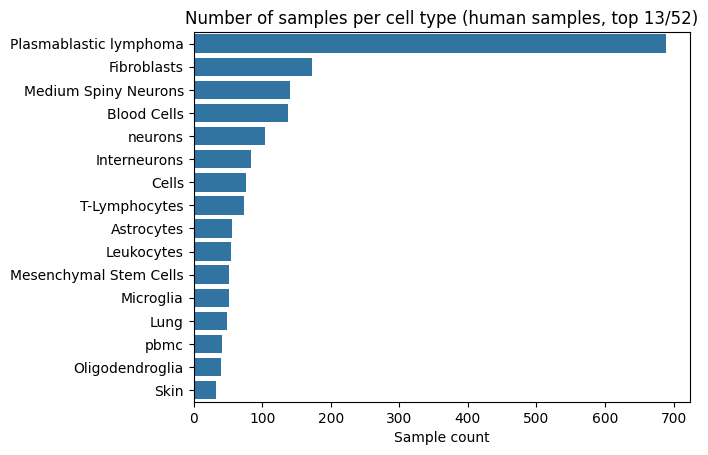

In [ ]:
reduced_cell_types_human = remove_low_frequency_levels(cell_types_standardized_human, 30)
print(f"Total unique: {len(cell_types_standardized_human.value_counts().index)}")
sns.countplot(reduced_cell_types_human, order=reduced_cell_types_human.value_counts().index)
plt.title("Number of samples per cell type (human samples, top 13/52)")
plt.xlabel("Sample count")

Total unique: 46


Text(0.5, 0, 'Sample count')

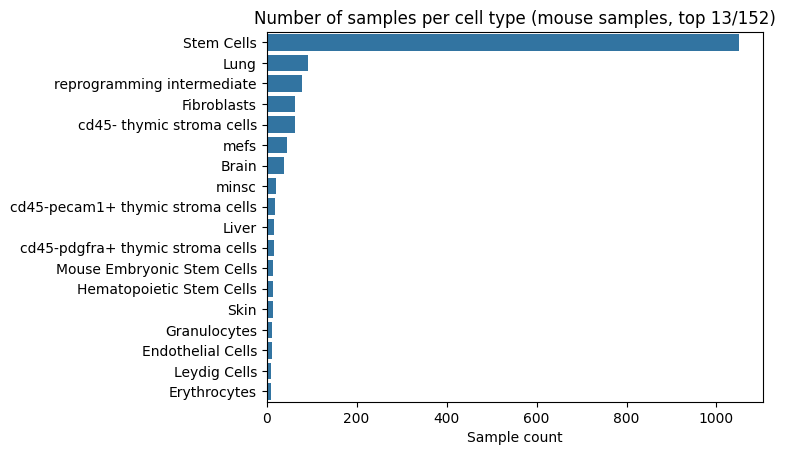

In [ ]:
reduced_cell_types_mice = remove_low_frequency_levels(cell_types_standardized_mice, 10)
print(f"Total unique: {len(cell_types_standardized_mice.value_counts().index)}")
sns.countplot(reduced_cell_types_mice, order=reduced_cell_types_mice.value_counts().index)
plt.title("Number of samples per cell type (mouse samples, top 13/152)")
plt.xlabel("Sample count")

In [ ]:
def get_standard_names_for_characteristic(dataset, characteristic: str) -> Set[str]:
    return {
        get_standard_name(sample.characteristics[characteristic], standardization_resources) or sample.characteristics[characteristic]
        for sample in dataset.samples if characteristic in sample.characteristics
    }

Text(0.5, 0, 'Dataset count')

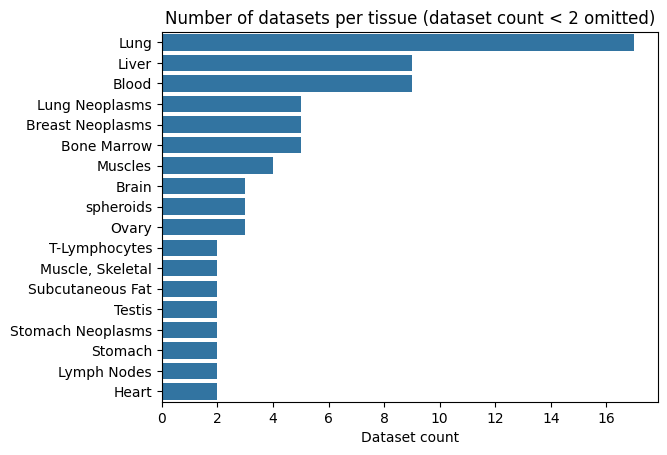

In [ ]:
tissues_datasets_level_human = pd.Series(itertools.chain.from_iterable(get_standard_names_for_characteristic(dataset, "tissue") for dataset in human_datasets))
reduced_tissues_datasets_level_human = remove_low_frequency_levels(tissues_datasets_level_human, 2)
sns.countplot(reduced_tissues_datasets_level_human, order=reduced_tissues_datasets_level_human.value_counts().index)
plt.title("Number of datasets per tissue (dataset count < 2 omitted)")
plt.xlabel("Dataset count")

# Source name analysis

In [ ]:
samples_that_do_not_contain_tissue_nor_cell_type = [
    sample for sample in samples if "tissue" not in sample.characteristics and "cell type" not in sample.characteristics
]
import random
for i in range(20):
    random_sample = random.choice(samples_that_do_not_contain_tissue_nor_cell_type)
    print(random_sample.accession)
    print(random_sample.metadata.get("source_name_ch1", "N/A"))

GSM2529124
['Primary breast tumor']
GSM3548458
['pancreatic islets']
GSM1354135
['CD14+ cell']
GSM3552324
['pancreatic islets']
GSM4600586
['Whole Blood']
GSM2172483
['Pancreatic islet']
GSM4599269
['Whole Blood']
GSM5369679
['Homo sapiens male adult (42 years) T-cell primary cell']
GSM3546838
['pancreatic islets']
GSM3549246
['pancreatic islets']
GSM2529928
['Primary breast tumor']
GSM2172016
['Pancreatic islet']
GSM5264885
['HEK293']
GSM1354241
['CD14+ cell']
GSM2530015
['Primary breast tumor']
GSM3552001
['pancreatic islets']
GSM4599863
['Whole Blood']
GSM1213746
['Primary NSCLC']
GSM3552511
['pancreatic islets']
GSM6171413
['stroke patients first 24 h 62']


In [ ]:
source_names = [sample.metadata["source_name_ch1"][0] for sample in samples_that_do_not_contain_tissue_nor_cell_type if "source_name_ch1" in sample.metadata]
standardized_sample_names = [get_standard_name(source_name, standardization_resources) for source_name in source_names]
sample_name_seems_to_have_been_parsed = [sample_name for sample_name in standardized_sample_names if sample_name is not None]

In [ ]:
print("Parsed sample names:", len(sample_name_seems_to_have_been_parsed))
print("Total sample names:", len(source_names))

Parsed sample names: 20950
Total sample names: 24116


In [ ]:
page = 213
for i in range(page * 20, (page+1)*20):
    print(f"{source_names[i]} | {standardized_sample_names[i]}")

blood | Blood
CD14+ cell | None
pancreatic islets | Islets of Langerhans
Heart | Heart
Primary breast tumor | Breast Neoplasms
serum, after diagnostic liver biopsy, MASLD w/o MASH | Serum
lung adenocarcinoma | Adenocarcinoma of Lung
pancreatic islets | Islets of Langerhans
Pancreatic islet | Islets of Langerhans
Pancreatic islet | Islets of Langerhans
pancreatic islets | Islets of Langerhans
liver, conditional Keap1 knockout, Alb-Cre::Keap1(flox/-) | Liver
pancreatic islets | Islets of Langerhans
Breast tumor biospsie | Breast Neoplasms
Primary breast tumor | Breast Neoplasms
HeLa S3 | HeLa Cells
Primary breast tumor | Breast Neoplasms
Adenocarcinoma of the Lung | Adenocarcinoma of Lung
Primary breast tumor | Breast Neoplasms
Pancreatic islet | Islets of Langerhans


In [ ]:
import json
mesh_lookup_writeable = {key: list(value) for key, value in mesh_lookup.items()}
mesh_lookup_writeable = {key: max(value) for key, value in mesh_lookup_writeable.items()}
mesh_lookup_writeable = {key: (value) for key, value in mesh_lookup_writeable.items() if value.startswith("A") or value.startswith("C04.588")}
mesh_lookup_writeable = {key: (value) for key, value in mesh_lookup_writeable.items() if len(value.split(".")) >= 2}
unique_mesh_terms = []
unique_ids = set()
unique_mesh_terms.append(f"mesh_id,term\n")
for key, values in mesh_lookup_writeable.items():
    unique_mesh_terms.append(f'"{values}","{key}"\n')
    if values not in unique_ids:
        unique_ids.add(values)

with open("mesh_terms.csv", "w") as f:
    f.writelines(unique_mesh_terms)

In [ ]:
print(sum(len(mesh_term.split(" ")) for mesh_term in unique_mesh_terms))

37518


In [ ]:
with open("unique_tissues_and_cell_types.txt", "w") as f:
    f.writelines(f"'{tissue}',\n" for tissue in unique_tissues)
    f.writelines(f"'{cell_type}',\n" for cell_type in unique_cell_types)

# Characteristics per cluster

In [ ]:
clusters_geo_ids = best_result.df.groupby(best_result.df["cluster"])["id"].apply(list).to_dict()

In [ ]:
def get_dataset_by_id(datasets, id):
    return next(filter(lambda dataset: dataset.id == id, datasets))


def get_all_characteristics_keys(geo_ids: List[str], datasets):
    characteristics_keys = []
    for id in geo_ids:
        dataset = get_dataset_by_id(datasets, id)
        samples = dataset.samples
        for sample in samples:
            characteristics_keys += list(sample.characteristics.keys())

    return characteristics_keys

In [ ]:
all_characteristics_keys_per_cluster = {
    cluster: get_all_characteristics_keys(geo_ids, datasets) 
    for cluster, geo_ids in clusters_geo_ids.items()
}

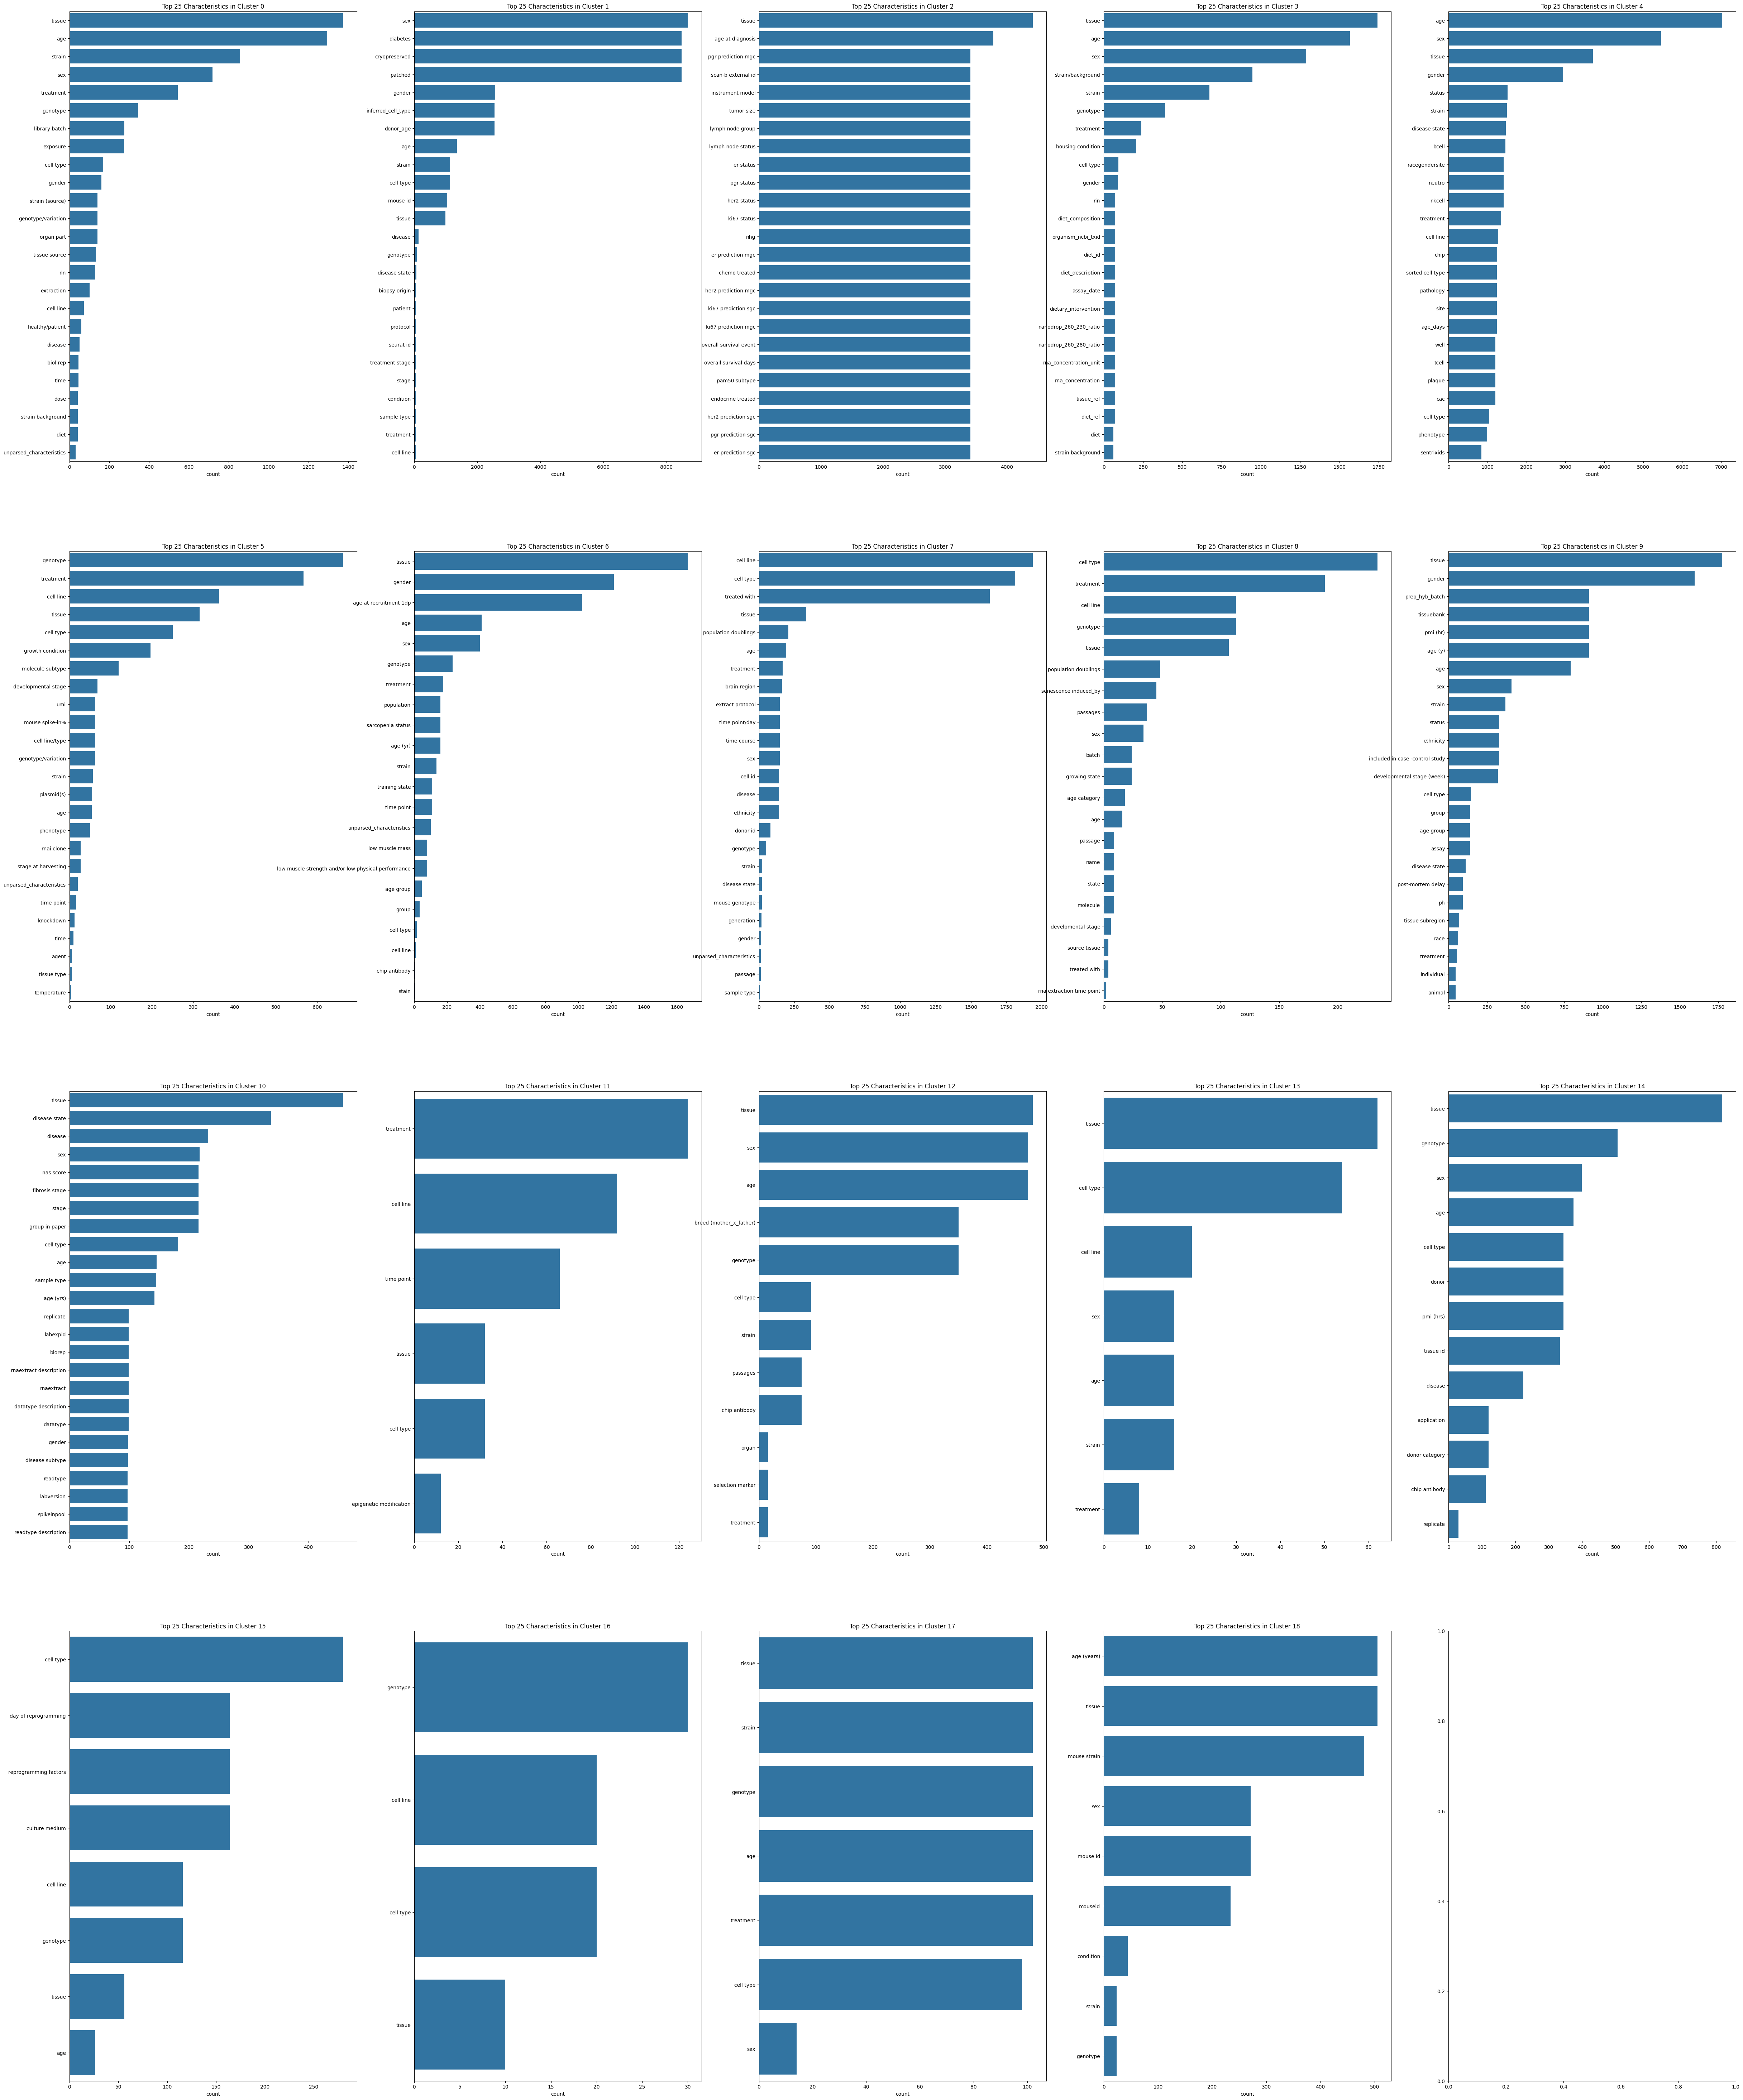

In [ ]:
fig, axes = plt.subplots(4, 5, figsize=(60, 75))
for i, cluster in enumerate(all_characteristics_keys_per_cluster):
    characteristics_keys = pd.Series(all_characteristics_keys_per_cluster[cluster])
    sns.countplot(all_characteristics_keys_per_cluster[cluster], ax=axes[i//5, i % 5], order=characteristics_keys.value_counts().index[0:25])
    axes[i//5, i%5].set_title(f"Top 25 Characteristics in Cluster {cluster}")

## Sunburst chart

In [19]:
import pandas as pd
import numpy as np
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.palettes import Category20c
from textwrap import wrap
import colorcet as cc


data = {
    'id': ['/lib', '/home', '/home/user', '/home/user/data', '/home/user/docs', '/tmp'],
    'parent': ['', '', '/home', '/home/user', '/home/user', ''],
    'name': ['lib', 'home', 'user', 'data', 'docs', 'tmp'],
    'value': [25, 0, 0, 40, 35, 25] # Values for children
}
df = pd.DataFrame(data)

def calculate_internal_node_values(plot_df):
    """
    Calculates values for non-leaf nodes.
    """
    current_level_items = plot_df.loc[~plot_df["id"].isin(plot_df["parent"]), :]
    while len(current_level_items) > 0:
        parents_of_current_level = plot_df.loc[current_level_items.index, "parent"].tolist()
        for parent_id in set(parents_of_current_level):
            plot_df.loc[plot_df["id"] == parent_id, "value"] = current_level_items.loc[plot_df["parent"] == parent_id, "value"].sum()

        current_level_items = plot_df.loc[plot_df["id"].isin(parents_of_current_level), :]

    return plot_df


def calculate_angles_and_radii(df, ring_width, root_id=""):
    """ 
    Calculates angles and radii for the sunburst chart. 
    Also calculates values for non-leaf nodes.
    The values of internal nodes are calculated as the sum
    of their descendants' values.
    """
    # Work on a copy to avoid modifying the original DataFrame
    plot_df = df.copy()

    # Initialize columns
    plot_df['angle'] = 0.0
    plot_df['start_angle'] = 0.0
    plot_df['end_angle'] = 0.0
    plot_df['inner_radius'] = 0.0
    plot_df['outer_radius'] = 0.0

    total_value = plot_df["value"].sum()

    plot_df = calculate_internal_node_values(plot_df)
    
    plot_df["angle"] = plot_df["value"] / total_value * 2 * np.pi

    plot_df = plot_df.sort_values(by="value", ascending=False)

    def calculate_angles(parent_id, start_angle, level):
        children = plot_df[plot_df['parent'] == parent_id]
        current_angle = start_angle
        
        for idx, child in children.iterrows():
            plot_df.loc[idx, 'start_angle'] = current_angle
            end_angle = current_angle + child['angle']
            plot_df.loc[idx, 'end_angle'] = end_angle
            
            plot_df.loc[idx, 'inner_radius'] = level*ring_width
            plot_df.loc[idx, 'outer_radius'] = level*ring_width + ring_width
            
            calculate_angles(child['id'], current_angle, level + 1)

            current_angle = end_angle

    calculate_angles(root_id, 0, 1) # Start at level 1

    return plot_df



def add_wedge_color(plot_df, root_id=""):
    plot_df = plot_df.copy()
    # Create a color map
    # Note: Use a larger palette if you have more top-level categories
    plot_df["color"] = "#000000"
    number_of_categories = len(plot_df[plot_df['parent'] == root_id])
    palette = None
    if number_of_categories <= 20:
        palette = Category20c[max(number_of_categories, 3)]
    else:
        palette = cc.glasbey[:number_of_categories]

    for i, row in enumerate(plot_df[plot_df["parent"] == root_id].iterrows()):
        idx, _ = row
        plot_df.loc[idx, "color"] = palette[i]

    def _add_color(parent_id, color):
        children = plot_df[plot_df['parent'] == parent_id]
        
        for idx, child in children.iterrows():
            if color is not None:
                plot_df.loc[idx, "color"] = color

            _add_color(child['id'], plot_df.loc[idx, "color"])

    _add_color(root_id, None) # Start at level 1
    return plot_df

def get_contrasting_text_color(hex_color):
    """
    Calculates whether black or white text is more readable against a given
    hex background color.
    
    Args:
        hex_color (str): The background color in hex format (e.g., "#RRGGBB").
        
    Returns:
        str: "white" or "black".
    """
    hex_color = hex_color.lstrip('#')
    r_int, g_int, b_int = int(hex_color[0:2], 16), int(hex_color[2:4], 16), int(hex_color[4:6], 16)
    
    # Calculate luminance
    # Formula from WCAG guidelines: https://www.w3.org/TR/WCAG20-TECHS/G17.html
    rgb = []
    for c_int in [r_int, g_int, b_int]:
        c = c_int / 255.0
        if c <= 0.03928:
            c = c / 12.92
        else:
            c = ((c + 0.055) / 1.055) ** 2.4
        rgb.append(c)
        
    luminance = 0.2126 * rgb[0] + 0.7152 * rgb[1] + 0.0722 * rgb[2]
    
    return 'black' if luminance > 0.5 else 'white'

def calculate_text_positions(plot_df):
    plot_df = plot_df.copy()
    center_angle = (plot_df['start_angle'] + plot_df['end_angle']) / 2
    center_radius = (plot_df['inner_radius'] + plot_df['outer_radius']) / 2

    plot_df['text_x'] = center_radius * np.cos(center_angle)
    plot_df['text_y'] = center_radius * np.sin(center_angle)
    plot_df['text_angle'] = center_angle
    # Flip texts in the left half of the sunburst so they do not appear upside down
    plot_df.loc[plot_df["text_angle"].between(np.pi/2, 3 * np.pi/2), "text_angle"] += np.pi
    return plot_df

def add_text_color(plot_df):
    plot_df = plot_df.copy()
    plot_df["text_color"] = plot_df["color"].map(get_contrasting_text_color)
    return plot_df


def process_data_for_sunburst(df, ring_width, root_id=""):
    plot_df = calculate_angles_and_radii(df, ring_width, root_id)
    plot_df = add_wedge_color(plot_df, root_id)
    plot_df = calculate_text_positions(plot_df)
    plot_df = add_text_color(plot_df)
    return plot_df



def plot_sunburst(df, title, ring_width=0.8, max_text_width=23, root_id=""):
    plot_df = process_data_for_sunburst(df, ring_width, root_id)
    plot_df["name"] = plot_df["name"].map(lambda name: "\n".join(wrap(name, width=max_text_width)))
    source = ColumnDataSource(plot_df)

    p = figure(
        width=1200, 
        height=1200, 
        title=title,
        x_axis_type=None, 
        y_axis_type=None,
        x_range=(-4, 4), 
        y_range=(-4, 4),
        min_border=0,
        outline_line_color=None,
        background_fill_color="#f0f0f0"
    )

    p.annular_wedge(
        x=0, 
        y=0,
        inner_radius='inner_radius',
        outer_radius='outer_radius',
        start_angle='start_angle',
        end_angle='end_angle',
        source=source,
        color="color",
        line_color='white',
        line_width=2
    )


    p.text(
        x='text_x',
        y='text_y',
        text='name',           # Use the 'name' column for the text
        angle='text_angle',    # Rotate text to match the wedge angle
        source=source,
        text_align='center',
        text_baseline='middle',
        text_font_size='11px',
        text_color='text_color'
    )

    hover = HoverTool(tooltips=[("Name", "@name"), ("Count", "@value")])
    p.add_tools(hover)

    p.grid.grid_line_color = None

    show(p)
    return p

plot_sunburst(df, "File System Sunburst Chart")

figure(id='p1064', ...)

In [20]:
%autoreload 1
%aimport src.tissue_and_cell_type_standardization.get_standard_name_bern2
%aimport src.tissue_and_cell_type_standardization.ner_nen_pipeline
from functools import lru_cache
from src.tissue_and_cell_type_standardization.get_standard_name_bern2 import get_standard_name_bern2
from src.tissue_and_cell_type_standardization.is_mesh_term_in_anatomy_or_disease import is_term_in_one_of_categories, build_mesh_lookup
from src.tissue_and_cell_type_standardization.ner_nen_pipeline import NER_NEN_Pipeline

class StandardizationResources:
    def __init__(self, mesh_lookup, category_filter = None):
        if category_filter is not None:
            self.mesh_lookup = {key: entry for key, entry in mesh_lookup.items() if is_term_in_one_of_categories(key, mesh_lookup, category_filter)}
        else:
            self.mesh_lookup = mesh_lookup
        self.case_insensitive_mesh_lookup = {key.strip().lower(): entry
                                        for key, entry in self.mesh_lookup.items()}
        self.mesh_id_to_term_map = {}
        for key, entry in self.mesh_lookup.items():
            if entry.id not in self.mesh_id_to_term_map or len(key) < len(self.mesh_id_to_term_map[entry.id]):
                self.mesh_id_to_term_map[entry.id] = key.strip().lower()

        self.mesh_term_to_id_map = {key.strip().lower(): entry.id for key, entry in self.mesh_lookup.items()}

        self.mesh_tree_number_to_term_map = {}
        for term, entry in self.mesh_lookup.items():
            for tree_number in entry.tree_numbers:
                if tree_number not in self.mesh_tree_number_to_term_map or len(term) < len(self.mesh_tree_number_to_term_map[tree_number]):
                    self.mesh_tree_number_to_term_map[tree_number] = term


def find_nth(haystack: str, needle: str, n: int) -> int:
    start = haystack.find(needle)
    while start >= 0 and n > 1:
        start = haystack.find(needle, start+len(needle))
        n -= 1
    return start

def get_parent_tree_number(tree_number, level = 2):
    end_of_parent_tree_number = find_nth(tree_number, ".", level)
    if end_of_parent_tree_number == -1:
        return tree_number
    return tree_number[:find_nth(tree_number, ".", level)]


def get_characteristic_values(datasets, characteristic: str = "disease state"):
    characteristic_values_per_dataset = []
    for dataset in datasets:
        samples_with_characteristic = filter(
            lambda sample: characteristic in sample.characteristics, dataset.samples)
        characteristic_values_per_dataset.extend(
            list(set(sample.characteristics[characteristic]
                 for sample in samples_with_characteristic))
        )
    return characteristic_values_per_dataset


def get_tree_number(term, mesh_lookup):
    tree_numbers = mesh_lookup[term].tree_numbers
    priority_prefixes = [
        "A11.118",
        "A15.145"
    ]
    for prefix in priority_prefixes:
        parent_tree_number = next((tn for tn in tree_numbers if tn.startswith(prefix)), None)
        if parent_tree_number:
            return parent_tree_number
    
    return next(iter(tree_numbers))




def normalize_terms(values, normalization_prefix, normalization_pipeline):
    @lru_cache
    def _get_standard_value(value):
        mentions = normalization_pipeline(f"{normalization_prefix}: {value}")
        return max(mentions, key=lambda x: x.score)
    return list(map(_get_standard_value, values))



def get_parent_terms(standardized_terms, standardization_resources, level):
    tree_numbers = [
        get_tree_number(standard_value, mesh_lookup)
        for standard_value in standardized_terms
    ]
    parent_tree_numbers = [
        get_parent_tree_number(tree_number, level)
        for tree_number in tree_numbers
    ]
    parent_terms = [
        standardization_resources.mesh_tree_number_to_term_map[tree_number] 
        for tree_number in parent_tree_numbers
    ]
    return parent_terms


def assign_unique_ids(values, start_id):
    value_to_id = {}
    for value in values:
        if value not in value_to_id:
            value_to_id[value] = start_id
            start_id += 1
    
    return list(map(lambda x: value_to_id[x], values)), start_id, value_to_id

def get_standardized_characteristic_counts(datasets, characteristic: str, standardization_resources: StandardizationResources, normalization_pipeline, parent_levels: List[int]):
    characteristic_values = get_characteristic_values(datasets, characteristic)
    normalized_mentions = normalize_terms(characteristic_values, f"{characteristic}:", normalization_pipeline)
    names = []
    parents = []
    values = []
    terms = list(map(lambda x: standardization_resources.mesh_id_to_term_map[x.cui], normalized_mentions))    
    current_id = 0
    ids, current_id, _ = assign_unique_ids(terms, 0)

    for level in sorted(parent_levels, reverse=True):
        names.extend(terms)

        parent_terms = get_parent_terms(terms, standardization_resources, level)
        parent_ids, current_id, parent_to_id = assign_unique_ids(parent_terms, current_id)
        parents.extend(parent_ids)
        ids.extend(parent_to_id.values())

        if not values:
            values.extend([1] * len(terms))
        else:
            values.extend([0] * len(terms))

        terms = list(parent_to_id.keys())
    
    names.extend(terms)
    parents.extend([-1] * len(terms))
    values.extend([0] * len(terms))

    print(len(ids))
    print(len(names))
    print(len(parents))
    print(len(values))

    df = pd.DataFrame({
        "id": ids,
        "name": names,
        "parent": parents,
        "value": values
    })
    # Remove terms that seem to be parents of themsevles
    df = df.loc[df["id"] != df["parent"], :]
    return pd.DataFrame(df)


In [21]:
from src.tissue_and_cell_type_standardization.get_standard_name_bern2 import get_standard_name_bern2, BERN2Recognizer
from src.tissue_and_cell_type_standardization.gliner_recognizer import GlinerRecognizer
from src.tissue_and_cell_type_standardization.ner_nen_pipeline import NER_NEN_Pipeline
from src.tissue_and_cell_type_standardization.angel_normalizer import ANGELMeshNormalizer
mesh_lookup = build_mesh_lookup("desc2025.xml")
standardization_resources = StandardizationResources(mesh_lookup, ["A"])
ner = GlinerRecognizer(["Cell type"])
angel_normalizer = ANGELMeshNormalizer(standardization_resources.mesh_term_to_id_map)
pipeline = NER_NEN_Pipeline(ner, angel_normalizer)
name_parent_df = get_standardized_characteristic_counts(datasets, "cell type", standardization_resources, pipeline, [3, 2])
print(name_parent_df)

/home/Momir.Milutinovic/repos/pubmed-paper-exploration/.venv/lib/python3.10/site-packages/transformers/models/bart/modeling_bart.py:785: FutureWarning: The class `PretrainedBartModel` has been depreciated, please use `BartPreTrainedModel` instead.
  warnings.warn(


[2025-08-05 15:58:50,978] [INFO] [real_accelerator.py:203:get_accelerator] Setting ds_accelerator to cuda (auto detect)
 [WARNING]  Please specify the CUTLASS repo directory as environment variable $CUTLASS_PATH
 [WARNING]  sparse_attn requires a torch version >= 1.5 and < 2.0 but detected 2.4
 [WARNING]  using untested triton version (3.0.0), only 1.0.0 is known to be compatible


/home/Momir.Milutinovic/repos/pubmed-paper-exploration/.venv/lib/python3.10/site-packages/deepspeed/runtime/zero/linear.py:49: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(ctx, input, weight, bias=None):
/home/Momir.Milutinovic/repos/pubmed-paper-exploration/.venv/lib/python3.10/site-packages/deepspeed/runtime/zero/linear.py:67: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, grad_output):


Building MeSH lookup from 'desc2025.xml'...
Lookup built successfully. Found 265680 unique terms.


Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/home/Momir.Milutinovic/repos/pubmed-paper-exploration/.venv/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


no finetune!
Setting no soft prompts!


100%|███████████████████████████████████████████████████| 16751/16751 [00:01<00:00, 14288.02it/s]



Input  :  START granulocytes END
Output :  granulocytes is granulocyte

Input  :  START cd4 t-cells END
Output :  cd4 t-cells is cd4 positive t lymphocytes

Input  :  START b-cells END
Output :  b-cells is b lymphocytes

Input  :  START cd8 t-cells END
Output :  cd8 t-cells is cd8 positive t lymphocytes

Input  :  START monocytes END
Output :  monocytes is monocyte

Input  :  START leydig cells END
Output :  leydig cells is leydig cell

Input  :  START dermal fibroblast END
Output :  dermal fibroblast is fibroblast

Input  :  START human nueronal cells END
Output :  human nueronal cells is progenitor cells

Input  :  START es-derived lung fibroblast cells END
Output :  es-derived lung fibroblast cells is endoplasmic reticulum

Input  :  START neurons END
Output :  neurons is neuron

Input  :  START primary lung fibroblasts END
Output :  primary lung fibroblasts is fibroblasts

Input  :  START fibroblast END
Output :  fibroblast is fibroblasts

Input  :  START etoposide-induced senesce

In [22]:
from bokeh.io import export_png
plot_df = name_parent_df.groupby(["id", "name", "parent"]).agg(value=("value", "sum")).reset_index()
plot_df = plot_df.loc[plot_df["id"] != plot_df["parent"], :]
fig = plot_sunburst(plot_df, "Cell Types", ring_width=1, root_id=-1)
export_png(fig)

'/home/Momir.Milutinovic/.pyenv/versions/3.10.18/lib/python3.10/runpy.png'